# **Telco Customer Churn**

## **Business Problem**

1. 26,53% of 7043 customers stopped using Telco Services which had a hit to the company's revenue.

## **Objectives**

1. Find the cause of churn via using Exploratory Data Analysis.
2. Predict customer churn.
3. Give company recommendations for minimizing churn rate.

## **Dataset Source**


https://www.kaggle.com/datasets/blastchar/telco-customer-churn

## **Data Preparation**

### **1. Import Libraries**

In [131]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from sklearn.model_selection import GridSearchCV

### **2. Import Data**


In [132]:
df = pd.read_csv('Telco-Customer-Churn.csv')

### **3. Function Helpers**

#### **3.1 Check Data**

In [133]:
def data_info(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()

    print (f'Rows,Columns {data.shape}')
    print (f'Duplicated Values {data.duplicated().sum()}')
    print('=====\n')

    check_df = pd.DataFrame ({'missingValue' : missing_values,
                          'percentMissing' : missing_perc,
                          'DataType' : data_type,
                          'Unique' : num_unique}).sort_values('percentMissing',ascending=False)

    return check_df


#### **3.2 Check Outlier**

In [134]:
def outlier(df, column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)

    outlier_count = 0

    def check_outlier(x):
        nonlocal outlier_count
        if x < lower or x > upper:
            outlier_count += 1

    df[column].apply(check_outlier)

    outlier_perc = round((outlier_count) / len(df) * 100, 2)

    print(f'===== {column} =====')
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    print(f'Number of outliers: {outlier_count} ({outlier_perc}%)\n')

#### **3.3 Statistics Check**

In [135]:
def check_dependency (data, x, y) :

    obs_x = pd.crosstab(data[x],data[y])
    chi2, p, dof, expected = chi2_contingency(obs_x)
    alpha = 0.05

    print(f'=== V1: {x} === V2: {y} ===')


    if p<alpha :
        print (f'Chi-square Statistic : {chi2} \np-value: {p} < {alpha} \nV1 and V2 are dependent (significant association)')
        print()

    else :
        print (f'Chi-square Statistic : {chi2} \np-value: {p} > {alpha} \nV1 and V2 are independent (no significant association)')
        print()

In [136]:
def check_ttest (data, x) :
    churn_yes = data[data['Churn']==1][x]
    churn_no  = data[data['Churn']==0][x]

    alpha = 0.05
    t_stat_total , p_value = ttest_ind(churn_yes,churn_no)

    if p_value < alpha :
        print(x)
        print(f'p_value {p_value} < alpha {alpha}, t_stat_total = {t_stat_total}')
        print('There are significant differences between target and predictor\n')

    else :
        print(x)
        print(f'p_value {p_value} > alpha {alpha}, t_stat_total = {t_stat_total}')
        print('There are NO significant differences between target and predicto\n')

#### **3.4. Model Evaluation**

In [137]:
def cross_val_recall (X, y, model) :
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  recall_scorer = make_scorer(recall_score)

  recall_score_mean = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer).mean()

  print(f" Average recall score: {recall_score_mean:.4f}")

In [138]:
def eval_model (X_train, y_train, X_test, y_test, model, isTrain=False) :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)
    
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    
    print(f"ACCURACY: {accuracy:.4f}\tPRECISION: {precision:.4f}\tRECALL: {recall:.4f}\tF1 SCORE: {f1:.4f}\tROC SCORE: {roc_score:.4f}\n")
    if isTrain :
        cross_val_recall(X_train, y_train, model)

    fig, ax = plt.subplots(figsize=(4,3))

    disp.plot(ax=ax)


In [139]:
def hp_results (cv):
    cv_result = pd.DataFrame(cv.cv_results_)
    retain_cols = ['params','mean_test_score','rank_test_score']

    print(f'Best Params: {cv.best_params_}\n')

    return cv_result[retain_cols]

### **4. Baseline Data Check**

In [140]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [141]:
data_info(df)

Rows,Columns (7043, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7043
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,object,6531
MonthlyCharges,0,0.0,float64,1585
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


**Observation**
1. `7043` rows of data with `21` data variables
2. No missing or duplicate values
3. `TotalCharges`'s data type needs to be changed due to the fact it's currently set to `object`. Since MonthlyCharges is `float64`, we assume that TotalCharges is supposed to be `float64` too.
4. `Churn` data is currently string, decided to change to `int` for better predicting

### **5. Descriptive Statistics**

In [142]:
# copy original file for safe keeping
df_ori = df.copy()

# turn SeniorCitizen from Int to Object for descritive statistics
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

# turn TotalCharges from object to float64, making it same type as MonthlyCharges for easier processing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [143]:
# group column names
num = ['tenure','MonthlyCharges', 'TotalCharges']
cat = ['SeniorCitizen', 'gender','Partner', 'Dependents','PhoneService', 'MultipleLines',
               'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling',
               'PaymentMethod', 'Churn']


In [144]:
#numerical analysis
df[num].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


In [145]:
#categorical analysis
df[cat].describe().T

,count,unique,top,freq
SeniorCitizen,7043,2,0,5901
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


**Observation**
1. `Churn` and `SeniorCitizen` are features with boolean data type either `1` or `0`. There is no need to further describe it.
2. `tenure` and `MonthlyCharges` have distributions that tend to be symmetrical because the difference in mean and median values is less than 15%
3. `TotalCharges` has an asymmetric distribution because it has a large difference between the mean and median values

### **6. Data Preprocessing**

In [146]:
# group column names
numerical = ['tenure','MonthlyCharges', 'TotalCharges','Churn']
categorical = ['SeniorCitizen', 'gender','Partner', 'Dependents','PhoneService', 'MultipleLines',
               'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling',
               'PaymentMethod']

customerDemographic = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
customerAccInfo = ['Contract', 'PaperlessBilling', 'PaymentMethod']
customerSpending = ['tenure', 'MonthlyCharges', 'TotalCharges']

allFeatures = ['SeniorCitizen', 'gender','Partner', 'Dependents','PhoneService', 'MultipleLines',
               'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling',
               'PaymentMethod', 'tenure','MonthlyCharges', 'TotalCharges']

In [147]:
# turn TotalCharges from object to float64, making it same type as MonthlyCharges for easier processing
df['SeniorCitizen'] = pd.to_numeric(df['SeniorCitizen'], errors='coerce')

# turn Churn target data to be int for predicting
df['Churn']= df['Churn'].replace(['No' ,'Yes'],[0,1])

In [148]:
data_info(df)

Rows,Columns (7043, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
TotalCharges,11,0.156183,float64,6530
customerID,0,0.000000,object,7043
DeviceProtection,0,0.000000,object,3
MonthlyCharges,0,0.000000,float64,1585
PaymentMethod,0,0.000000,object,4
PaperlessBilling,0,0.000000,object,2
Contract,0,0.000000,object,3
StreamingMovies,0,0.000000,object,3
StreamingTV,0,0.000000,object,3
TechSupport,0,0.000000,object,3


**Observation**
1. There seems to be `11` missing data in `TotalCharges`.
2. There is also `22` duplicated data, assuming due to the fact we changed `TotalCharges` data type.

**Check missing values**

In [149]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


Since only **0.15%** of data is null, we may delete the rows so that it doesn't effect out analysis later on.

In [150]:
# drop rows where TotalCharges isNaN and do not create a new dataset
df = df[df['TotalCharges'].notna()].reset_index(drop=True)

In [151]:
data_info(df)

Rows,Columns (7032, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


In [152]:
#check each data for uniqueness
df_columns = df.columns.tolist()
for column in df_columns:
    print(f"{column} : {df[column].unique()}")
    print('\n')

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']


gender : ['Female' 'Male']


SeniorCitizen : [0 1]


Partner : ['Yes' 'No']


Dependents : ['No' 'Yes']


tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]


PhoneService : ['No' 'Yes']


MultipleLines : ['No phone service' 'No' 'Yes']


InternetService : ['DSL' 'Fiber optic' 'No']


OnlineSecurity : ['No' 'Yes' 'No internet service']


OnlineBackup : ['Yes' 'No' 'No internet service']


DeviceProtection : ['No' 'Yes' 'No internet service']


TechSupport : ['No' 'Yes' 'No internet service']


StreamingTV : ['No' 'Yes' 'No internet service']


StreamingMovies : ['No' 'Yes' 'No internet service']


Contract : ['Month-to-month' 'One year' 'Two year']


PaperlessBilling : ['Yes' 'No']


PaymentMethod : ['Electronic 

**Summary 3**
1. A total of `11` **(0.15%)** data removed due to missing values.

In [153]:
new_df = df.copy()
df_ori = df.copy()

In [154]:
# Replace 'No' with 0 and 'Yes' with 1 in the 'PhoneService' column
new_df['PhoneService'] = new_df['PhoneService'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0, 'Yes' with 1, and 'No phone service' with 0 in the 'MultipleLines' column
new_df['MultipleLines'] = new_df['MultipleLines'].replace(['No' ,'Yes', 'No phone service'],[0, 1, 0])

# Replace 'No' with 0, 'Fiber optic' with 1, and 'DSL' with 0 in the 'InternetService' column
new_df['InternetService'] = new_df['InternetService'].replace({'No': 0, 'Fiber optic': 1, 'DSL': 1})

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineSecurity' column
new_df['OnlineSecurity'] = new_df['OnlineSecurity'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineBackup' column
new_df['OnlineBackup'] = new_df['OnlineBackup'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'DeviceProtection' column
new_df['DeviceProtection'] = new_df['DeviceProtection'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'TechSupport' column
new_df['TechSupport'] = new_df['TechSupport'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingTV' column
new_df['StreamingTV'] = new_df['StreamingTV'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingMovies' column
new_df['StreamingMovies'] = new_df['StreamingMovies'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

In [155]:
new_df['SubscribedServices'] = new_df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']].sum(axis=1)
df['SubscribedServices'] = new_df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']].sum(axis=1)

In [156]:
new_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
0,7590-VHVEG,Female,0,Yes,No,1,0,0,1,0,...,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,0,2
1,5575-GNVDE,Male,0,No,No,34,1,0,1,1,...,0,0,0,One year,No,Mailed check,56.95,1889.50,0,4
2,3668-QPYBK,Male,0,No,No,2,1,0,1,1,...,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,1,4
3,7795-CFOCW,Male,0,No,No,45,0,0,1,1,...,1,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,0,4
4,9237-HQITU,Female,0,No,No,2,1,0,1,0,...,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


In [157]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2


In [158]:
data_info(new_df)

Rows,Columns (7032, 22)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
gender,0,0.0,object,2
Churn,0,0.0,int64,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,int64,2
StreamingTV,0,0.0,int64,2


**Summary 4:**
1. Conduct label encoding to `PhoneService`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` for machine learning modelling.
2. Conduct specific label encoding for  `No phone service` and `No internet service` to `0` assuming that they do not subscribe to the certain service.
3. Create a new column called `SubscribedServices` to count the amount of subscribed services of a customer.

### **7. Exploratory Data Analysis**

#### **7.1 Check Outliers, Distribution, and Univariate Analysis**

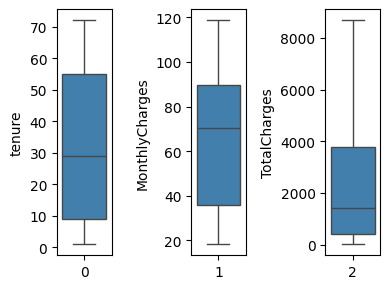

In [159]:
features = customerSpending
plt.figure(figsize=(4,3))
for i in range(0, len(features)):
  plt.subplot(1, len(features), i+1)
  sns.boxplot(x = i, y = df[features[i]], hue = i, palette = "tab20c", legend=False)
  plt.tight_layout()

In [160]:
outlier(df, 'tenure')

===== tenure =====
 outlier lower limit : -60.0 
 outlier upper limit : 124.0
Number of outliers: 0 (0.0%)



In [161]:
outlier(df, 'MonthlyCharges')

===== MonthlyCharges =====
 outlier lower limit : -45.824999999999996 
 outlier upper limit : 171.27499999999998
Number of outliers: 0 (0.0%)



In [162]:
outlier(df, 'TotalCharges')

===== TotalCharges =====
 outlier lower limit : -4688.481250000001 
 outlier upper limit : 8884.66875
Number of outliers: 0 (0.0%)



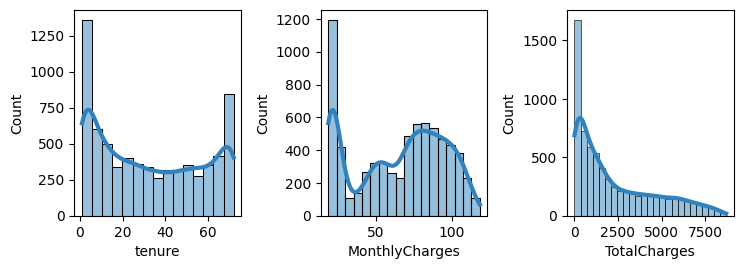

In [163]:
features = customerSpending
plt.figure(figsize=(10,5))
for i in range(0, len(features)):
  plt.subplot(2, 4, i+1)
  sns.histplot(x=df[features[i]], hue = i, palette = "tab20c", legend=False, kde=True, line_kws={'linewidth': 3})
  plt.xlabel(features[i])
  plt.tight_layout()

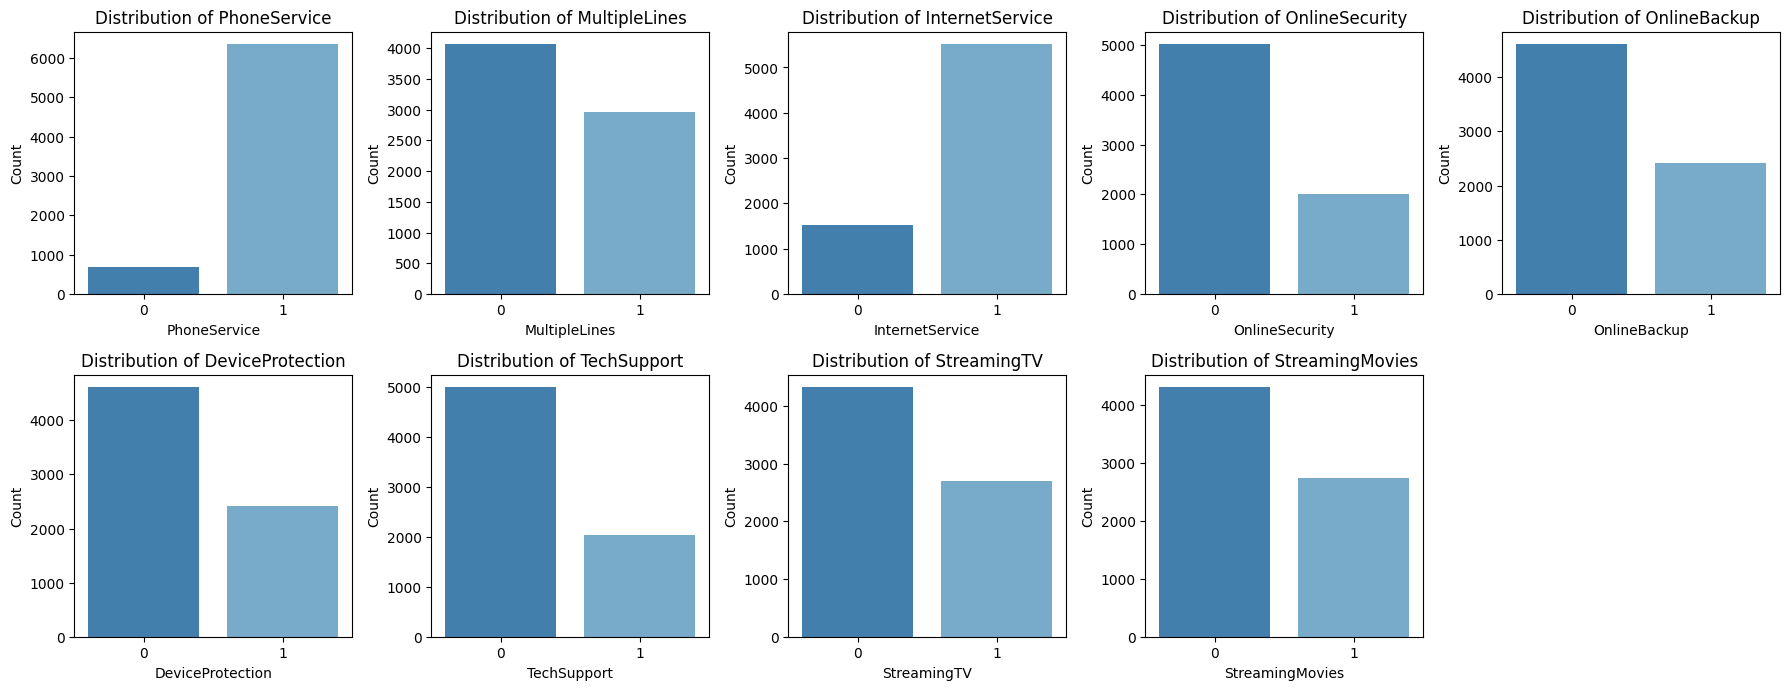

In [164]:
num_rows = len(services) // 2 + len(services) % 2
plt.figure(figsize=(18, 10))

for i, col in enumerate(services, start=1):
    plt.subplot(3, num_rows, i)
    sns.countplot(x=col, hue=col, data=new_df, palette = "tab20c")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend([], frameon=False)

plt.tight_layout()
plt.show()

**Observation**
1. There are no outliers in either `tenure`, `MonthlyCharges` or `TotalCharges` which can be stated that data is distributed evenly.
2. Most customers are (at distribution peak):
  - ~ 4 `tenure`
  - ~ 10 `MonthlyCharges`
  - ~ 357 `TotalCharges`
3. `tenure` and `MonthlyCharges` both have bimodal skew which means there may be a gap in feature pricing (that customer may or may not subscribe to) that may impact customer's churn rate.
4. `TotalCharges` is positively skewd which means that most of the customers in this dataset tend to prefer smaller packages or not subscribing to lots of features.
5. Based on the distribution, `InternetService` may provide deep insight into why customers may churn, since it's upselling packages like `OnlineSecurity`, `TechSupport` etc may correlate to `InternetService`.

#### **7.2 Multivariate Analysis**

##### **7.2.1 Customer Demographic Analysis**

In [165]:
def predictor_target(data, pred, tgt='Churn'):
  service_churn_rate = data.groupby(pred)[tgt].value_counts(normalize=True).unstack().fillna(0) * 100
  ax = sns.barplot(x=service_churn_rate.index, y=1, data=service_churn_rate, color='skyblue')

  for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height / 2.), ha='center', va='center', fontsize=10, color='black')

    plt.title(f'Churn Rate (%) of {pred}')
    plt.xlabel(pred)
    plt.ylabel('Churn Rate')
    plt.ylim(0,100)

In [166]:
def pred_tgt_list(data, features, columns=1, width=10, height=5):
  num_rows = len(features) // 2 + len(features) % 2
  plt.figure(figsize=(width, height * num_rows))


  for i, col in enumerate(features, start=1):
      plt.subplot(num_rows, columns, i)
      predictor_target(data, col)
      plt.xlabel('')

  plt.tight_layout()
  plt.show()

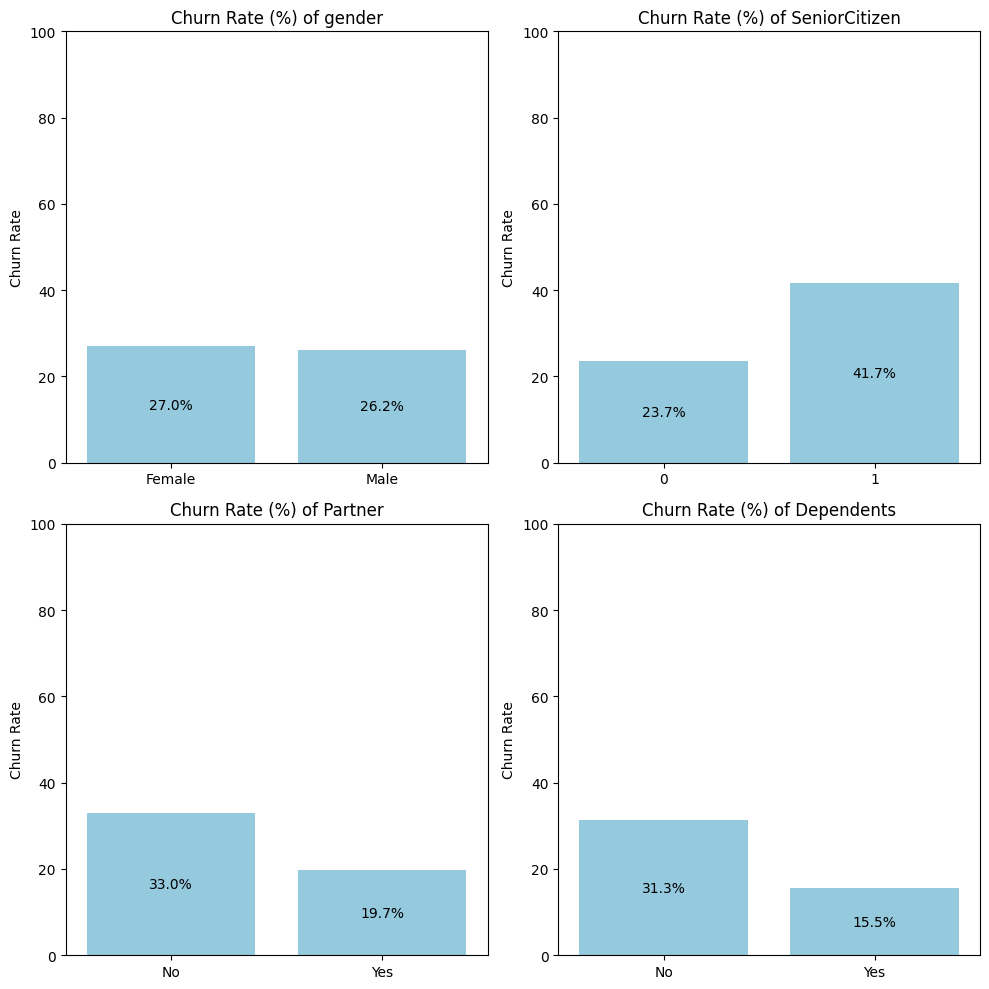

In [167]:
pred_tgt_list(new_df, customerDemographic, 2)

In [168]:
for x in customerDemographic :
    check_dependency(new_df, x,'Churn')

=== V1: gender === V2: Churn ===
Chi-square Statistic : 0.47545453727386294 
p-value: 0.490488470706551 > 0.05 
V1 and V2 are independent (no significant association)

=== V1: SeniorCitizen === V2: Churn ===
Chi-square Statistic : 158.4408162893713 
p-value: 2.4792557203954705e-36 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: Partner === V2: Churn ===
Chi-square Statistic : 157.50315146557506 
p-value: 3.97379757451591e-36 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: Dependents === V2: Churn ===
Chi-square Statistic : 186.32163933855873 
p-value: 2.0196592017051303e-42 < 0.05 
V1 and V2 are dependent (significant association)



**Observation**
1. `gender` does not correlate to `Churn` while `SeniorCitizen`, `Partner`, and `Dependents` do correlate.
2. Customers who are senior citizens do tend to churn.
3. Customers that have no partner (either single, divorced, deceased, etc) and have no dependents do tend to churn.

##### **7.2.2 Telco Services Analysis**

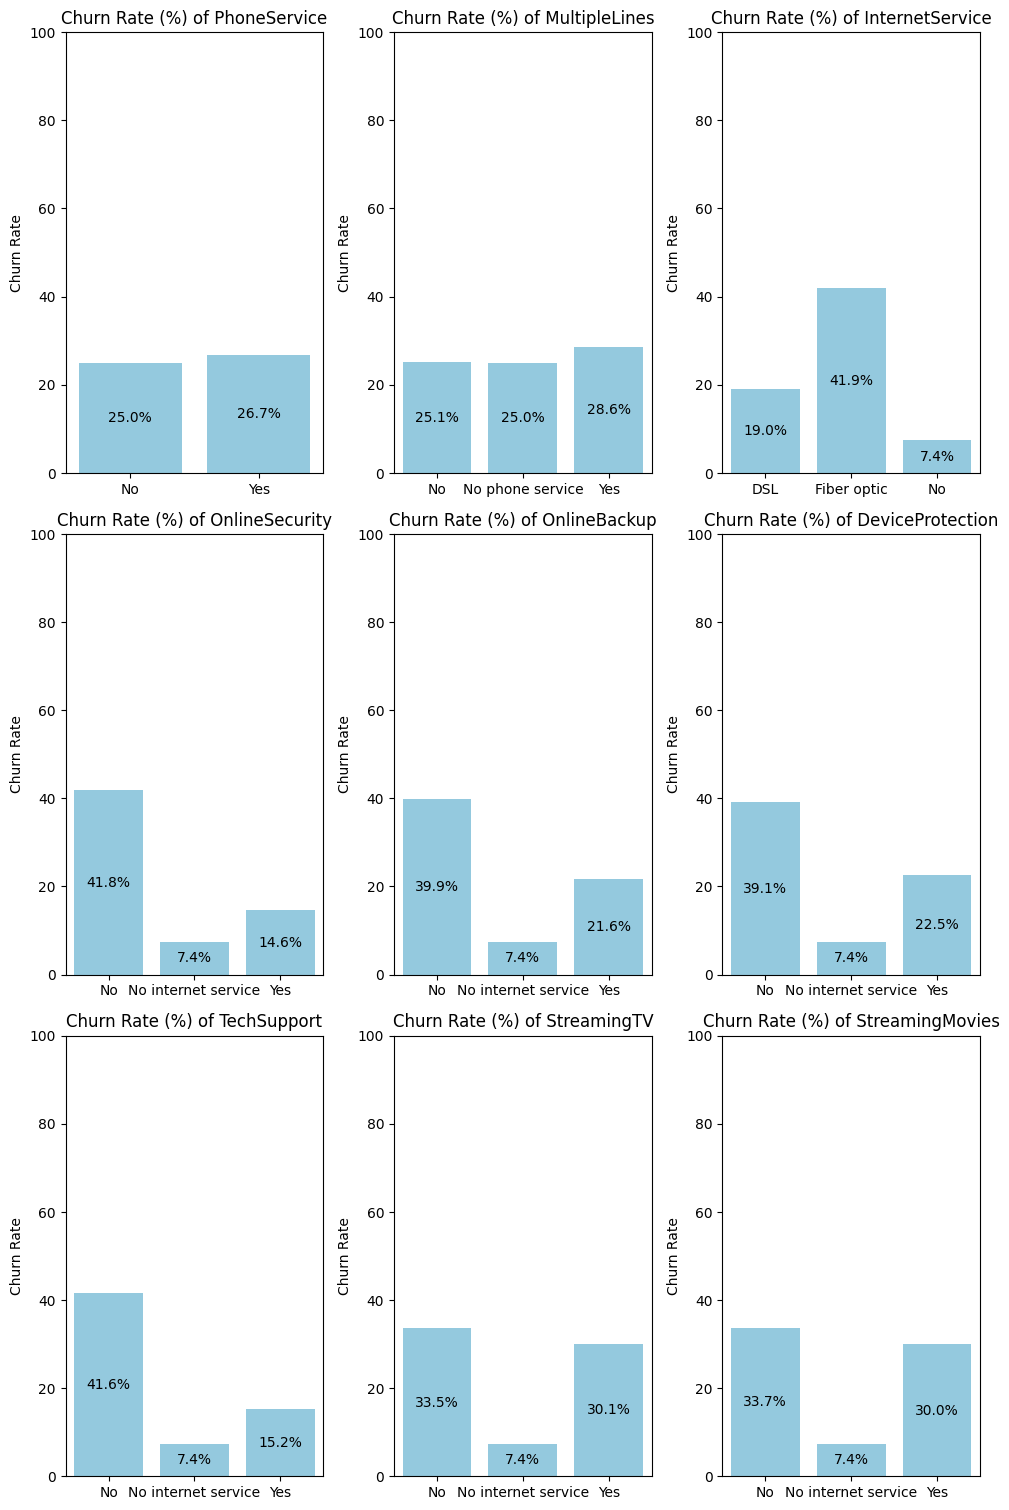

In [169]:
pred_tgt_list(df, services, 3)

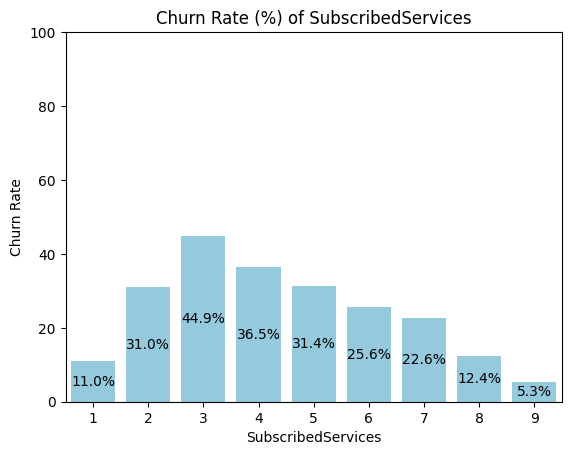

In [170]:
predictor_target(new_df, 'SubscribedServices')
plt.show()

In [171]:
for x in services :
    check_dependency(new_df, x,'Churn')

=== V1: PhoneService === V2: Churn ===
Chi-square Statistic : 0.8737327674431736 
p-value: 0.34992398942431924 > 0.05 
V1 and V2 are independent (no significant association)

=== V1: MultipleLines === V2: Churn ===
Chi-square Statistic : 11.08687591455858 
p-value: 0.0008694082815826175 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: InternetService === V2: Churn ===
Chi-square Statistic : 362.94784884289265 
p-value: 6.4225207979072035e-81 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineSecurity === V2: Churn ===
Chi-square Statistic : 205.41578737378245 
p-value: 1.37424000884718e-46 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineBackup === V2: Churn ===
Chi-square Statistic : 47.246659325881964 
p-value: 6.259257129714726e-12 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: DeviceProtection === V2: Churn ===
Chi-square Statistic : 30.49569910229676 
p-value: 3.346074945648779e-08 < 0.05 
V1 and V

**Observation**
1. `PhoneService` has no correlation to `Churn`.
2. Customers who subscribe to `MultipleLines` tend to churn.
3. Customers who subscribe to `Fiber Optic Internet Service` have a higher chance of churning than other options.
4. Customer that subscribed to an `InternetService` that do not use protection nor support like `OnlineSecurity`, `TechSupport`, `OnlineBackup`, `DeviceProtection` tend to be more likely to churn.
5. The more `SubscribedServices` by a customer, the less likely the tend to churn.

##### **7.2.3 Customer Account Info Analysis**


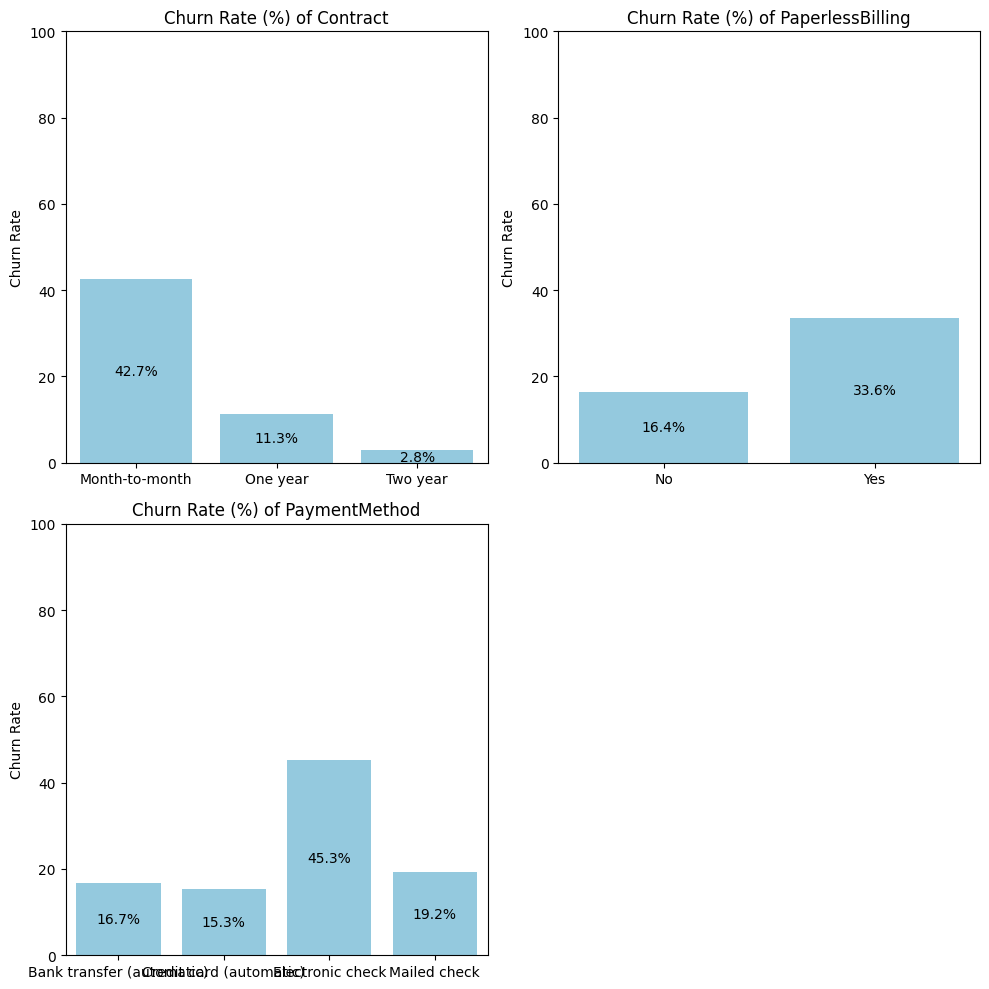

In [172]:
pred_tgt_list(df, customerAccInfo, 2, 10, 5)

In [173]:
for i in customerAccInfo :
    check_dependency(new_df, i,'Churn')

=== V1: Contract === V2: Churn ===
Chi-square Statistic : 1179.5458287339445 
p-value: 7.326182186265472e-257 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: PaperlessBilling === V2: Churn ===
Chi-square Statistic : 256.87490836218717 
p-value: 8.236203353962564e-58 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: PaymentMethod === V2: Churn ===
Chi-square Statistic : 645.4299001234638 
p-value: 1.4263098511063342e-139 < 0.05 
V1 and V2 are dependent (significant association)



**Observation**
1. Customers with month-to-month `Contract`, with `PaperlessBilling` and using electronic check `PaymentMethod` tend to churn.

##### **7.2.4 Customer Spending Analysis**

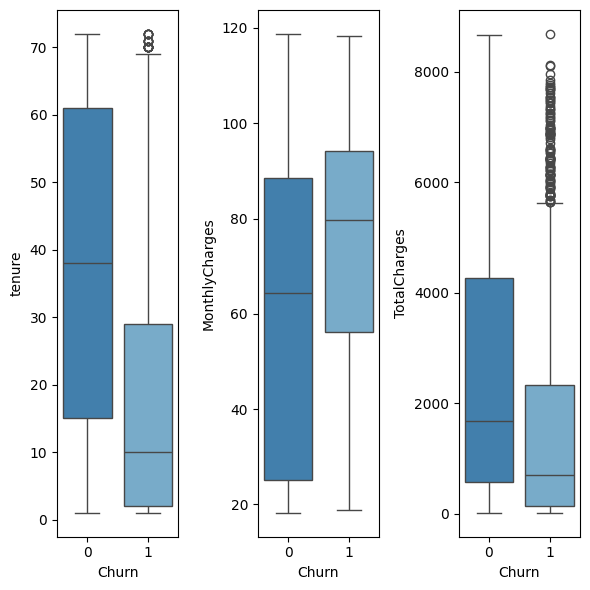

In [174]:
plt.figure(figsize=(6,6))

for x in range(0, len(customerSpending)):
    plt.subplot(1, len(customerSpending), x+1)
    sns.boxplot(x=new_df['Churn'],y=new_df[customerSpending[x]], palette = "tab20c")
    plt.tight_layout()

In [175]:
new_df[(new_df['TotalCharges']>=5800)&(new_df['Churn']==1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
104,3192-NQECA,Male,0,Yes,No,68,1,1,1,0,...,1,1,1,Two year,Yes,Bank transfer (automatic),110.00,7611.85,1,8
339,1343-EHPYB,Male,0,Yes,No,63,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,103.40,6603.00,1,7
402,0979-PHULV,Male,0,Yes,Yes,69,1,1,1,0,...,0,1,1,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,6
445,7752-XUSCI,Female,0,No,No,60,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,105.90,6396.45,1,7
608,3419-SNJJD,Female,1,Yes,No,65,1,1,1,1,...,0,1,1,Month-to-month,No,Bank transfer (automatic),105.25,6786.40,1,7
634,7207-RMRDB,Female,0,Yes,Yes,65,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,105.50,6985.65,1,7
797,3009-JWMPU,Male,0,No,No,62,1,1,1,0,...,0,1,1,One year,Yes,Electronic check,96.75,6125.40,1,6
808,2239-JALAW,Male,0,No,No,58,1,1,1,0,...,0,1,1,One year,Yes,Bank transfer (automatic),103.25,6017.65,1,7
809,4853-RULSV,Male,0,No,No,70,1,1,1,1,...,1,1,1,Two year,Yes,Credit card (automatic),104.00,7250.15,1,7
853,2382-BCKQJ,Female,0,No,Yes,62,1,1,1,0,...,0,1,1,One year,Yes,Electronic check,100.15,6413.65,1,6


In [176]:
new_df[(new_df['tenure']>=69)&(new_df['Churn']==1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SubscribedServices
402,0979-PHULV,Male,0,Yes,Yes,69,1,1,1,0,...,0,1,1,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,6
809,4853-RULSV,Male,0,No,No,70,1,1,1,1,...,1,1,1,Two year,Yes,Credit card (automatic),104.00,7250.15,1,7
972,2834-JRTUA,Male,0,No,No,71,1,1,1,1,...,1,1,1,Two year,Yes,Electronic check,108.05,7532.15,1,8
1302,0201-OAMXR,Female,0,No,No,70,1,1,1,1,...,1,1,1,One year,No,Credit card (automatic),115.55,8127.60,1,9
1962,0565-IYCGT,Male,0,No,No,69,1,1,1,1,...,1,0,1,One year,Yes,Credit card (automatic),78.60,5356.45,1,8
2282,5440-FLBQG,Male,1,Yes,No,69,1,1,1,0,...,1,1,1,Two year,Yes,Bank transfer (automatic),108.40,7318.20,1,8
2874,4550-VBOFE,Male,1,Yes,No,70,1,1,1,0,...,0,1,1,Month-to-month,Yes,Electronic check,102.95,7101.50,1,7
2992,1891-FZYSA,Male,1,Yes,No,69,1,1,1,0,...,0,1,0,Month-to-month,Yes,Electronic check,89.95,6143.15,1,5
3035,7317-GGVPB,Male,0,Yes,No,71,1,1,1,0,...,1,1,1,Two year,Yes,Credit card (automatic),108.60,7690.90,1,8
3106,8809-RIHDD,Male,0,Yes,Yes,72,1,1,1,0,...,0,1,1,Two year,Yes,Electronic check,103.40,7372.65,1,7


**Observation**
1. During plotting boxplot for `tenure` & `TotalChanges` alone there seems to be no outliers, but comparing it with `Churn` turns out there are outliers where `Churun` = 1
2. Outliers will be kept for further analysis because they provide data where they include high paying customers which include `InternetService` Fiber Optic, `OnlineSecurity`, etc, and they tend to stick around for a long `tenure` period.

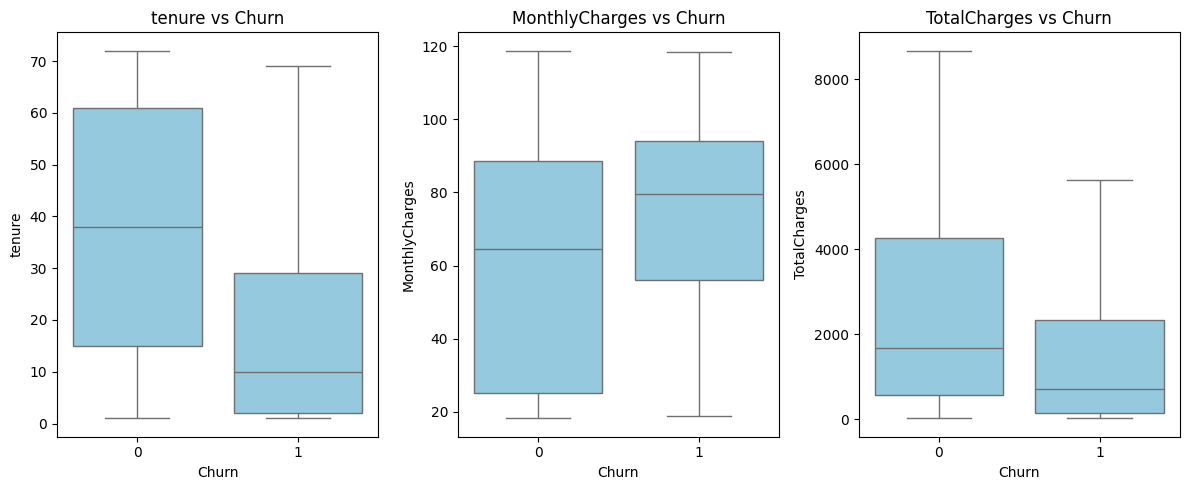

In [177]:
plt.figure(figsize=(12,5))

for i in range(0, len(customerSpending)):
    plt.subplot(1, len(customerSpending), i+1)
    sns.boxplot(x=new_df['Churn'],y=new_df[customerSpending[i]], color='skyblue',showfliers=False)
    plt.title(f'{customerSpending[i]} vs Churn')
    plt.tight_layout()

In [178]:
def predictor_target_num(data_frame, pred, tgt='Churn'):
  churn_rate = data_frame.groupby(tgt)[pred].mean().reset_index()
  ax = sns.barplot(x=tgt, y=pred, data=churn_rate, color='skyblue')

  for p in ax.patches:
      height = p.get_height()
      ax.annotate(f'{height:.1f}',
                  (p.get_x() + p.get_width() / 2., height / 2.),
                  ha='center', va='center',
                  fontsize=10, color='black')

  ax.set_ylabel('Churn Rate')
  ax.set_title(f'Churn Rate by Average {pred}')

  plt.show()

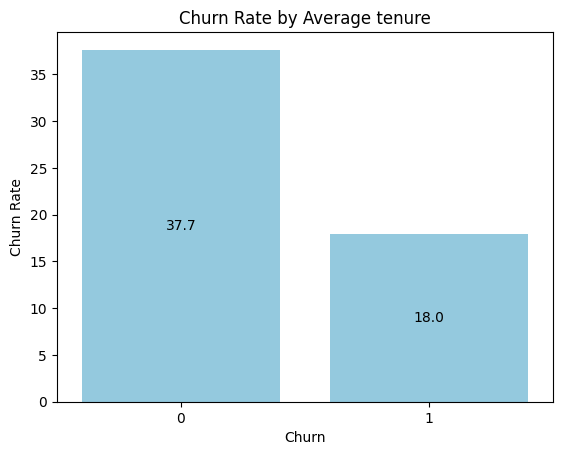

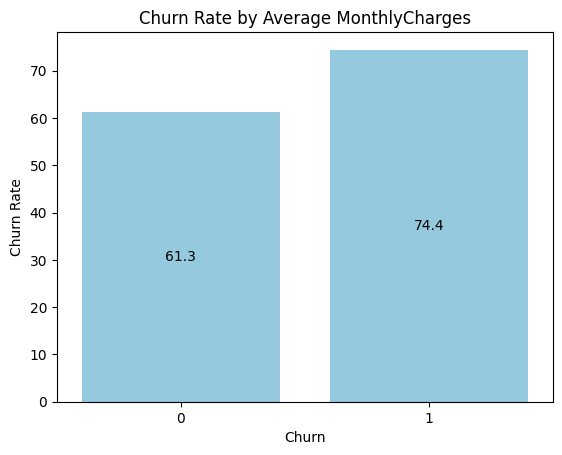

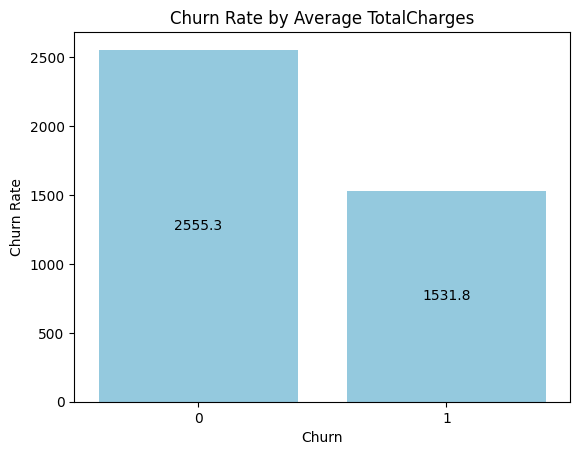

In [179]:
for i in customerSpending:
  predictor_target_num(new_df, i)

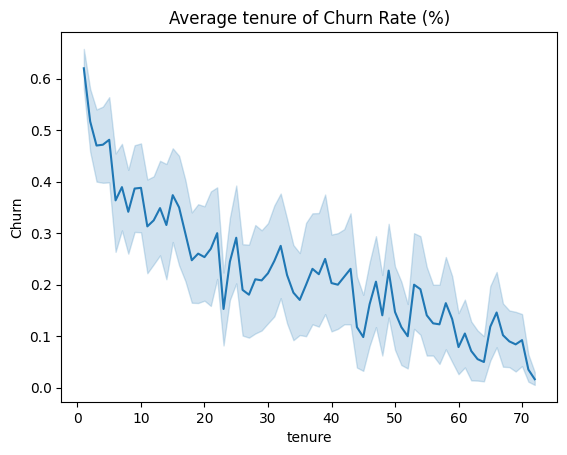

In [180]:
churn_rate = new_df.groupby('Churn')['tenure'].mean().reset_index()
sns.lineplot(x='tenure', y='Churn', data=new_df)

plt.title('Average tenure of Churn Rate (%)')
plt.show()

In [181]:
for i in customerSpending :
    check_ttest(new_df, i)

tenure
p_value 9.437650217574845e-207 < alpha 0.05, t_stat_total = -31.741289063447653
There are significant differences between target and predictor

MonthlyCharges
p_value 6.760843117980302e-60 < alpha 0.05, t_stat_total = 16.47959313114872
There are significant differences between target and predictor

TotalCharges
p_value 4.876865689694506e-64 < alpha 0.05, t_stat_total = -17.068827211220274
There are significant differences between target and predictor



**Observation**
1. Customers with low `tenure` tend to churn.
2. Customers that tend to churn have higher `MonthlyCharges` than those who do not churn.

### **8. Deep Dive Questions**


1. What service price affects customer's churn rate?
2. Is the price of `InternetService` fiber optic the reason for high churn rate?
3. Do customers with higher `tenure` tend to choose longer-term `Contracts`, and how does this impact their churn rate?
4. What services do customer choose based on the length of their tenure?

#### **8.1 How does price effect customer's churn rate?**

In [182]:
# define function to check mean of certain service based on MonthlyCharges
def avg_service_price(data_frame, service_column, charges_column='MonthlyCharges'):
    new_col_name = f'{service_column}-Charges'
    grouped_df = data_frame.groupby(service_column).agg(average_charges=(charges_column, 'mean')).reset_index()
    grouped_df = grouped_df.rename(columns={service_column: 'Service', 'average_charges': new_col_name})
    
    return grouped_df


In [183]:
df_1 = avg_service_price(df, 'InternetService')
df_1

,Service,InternetService-Charges
0,DSL,58.088017
1,Fiber optic,91.500129
2,No,21.076283


In [184]:
# since we want to know the price of internetService, we exclude "No" due to the fact it does not contain any InternetService
df_1 = df_1[df_1['Service']!='No']
df_1 = df_1.replace(['DSL','Fiber optic'],[0,1])
df_1

,Service,InternetService-Charges
0,0,58.088017
1,1,91.500129


In [185]:
df_2 = avg_service_price(new_df, 'MultipleLines')
df_2

,Service,MultipleLines-Charges
0,0,52.180935
1,1,82.084766


In [186]:
df_3 = avg_service_price(new_df, 'OnlineSecurity')
df_3

,Service,OnlineSecurity-Charges
0,0,59.146293
1,1,78.870496


In [187]:
df_4 = avg_service_price(new_df, 'OnlineBackup')
df_4

,Service,OnlineBackup-Charges
0,0,55.161265
1,1,83.106412


In [188]:
df_5 = avg_service_price(new_df, 'DeviceProtection')
df_5

,Service,DeviceProtection-Charges
0,0,54.287885
1,1,84.853888


In [189]:
df_6 = avg_service_price(new_df, 'TechSupport')
df_6

,Service,TechSupport-Charges
0,0,58.292198
1,1,80.718799


In [190]:
df_7 = avg_service_price(new_df, 'StreamingTV')
df_7

,Service,StreamingTV-Charges
0,0,49.829857
1,1,88.770829


In [191]:
df_8 = avg_service_price(new_df, 'StreamingMovies')
df_8

,Service,StreamingMovies-Charges
0,0,49.761962
1,1,88.478506


In [192]:
from functools import reduce

In [193]:
df_total_service = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8]

df_avg_service = reduce(lambda  left,right: pd.merge(left,right,on=['Service'],
                                            how='outer'), df_total_service)
df_avg_service

,Service,InternetService-Charges,MultipleLines-Charges,OnlineSecurity-Charges,OnlineBackup-Charges,DeviceProtection-Charges,TechSupport-Charges,StreamingTV-Charges,StreamingMovies-Charges
0,0,58.088017,52.180935,59.146293,55.161265,54.287885,58.292198,49.829857,49.761962
1,1,91.500129,82.084766,78.870496,83.106412,84.853888,80.718799,88.770829,88.478506


In [194]:
df_avg_service = df_avg_service.drop('Service',axis=1)

Text(0, 0.5, 'Ave Monthly Charges')

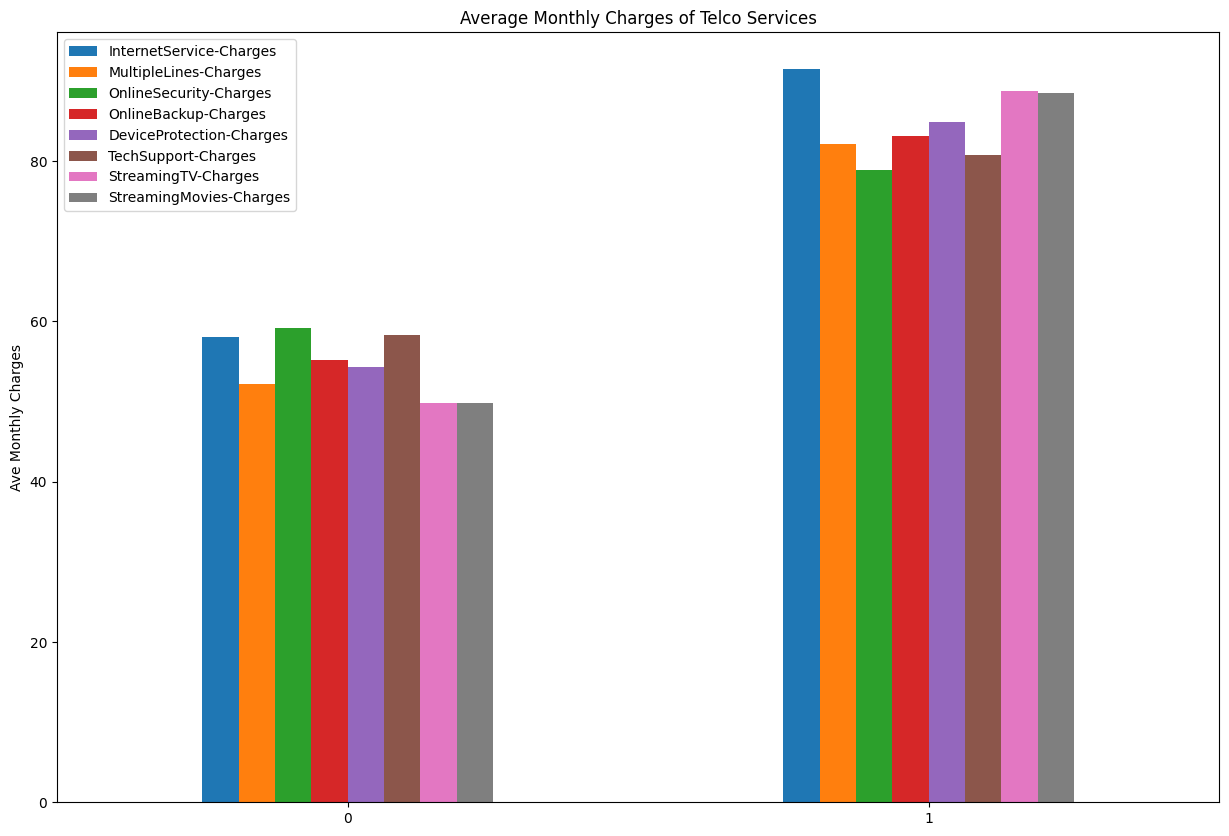

In [195]:
df_avg_service.plot(kind='bar',figsize=(15,10))
plt.title('Average Monthly Charges of Telco Services')
plt.xticks(rotation=0)
plt.ylabel('Ave Monthly Charges')

In [196]:
def plot_boxplot(hue_column, data=new_df, x_axis='SubscribedServices', y_axis='MonthlyCharges'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=x_axis, y=y_axis, hue=hue_column, showfliers=False)
    
    plt.ylabel(y_axis)
    plt.title(f'Distribution of {y_axis} by {hue_column} in {x_axis}', fontsize=16)
    plt.show()

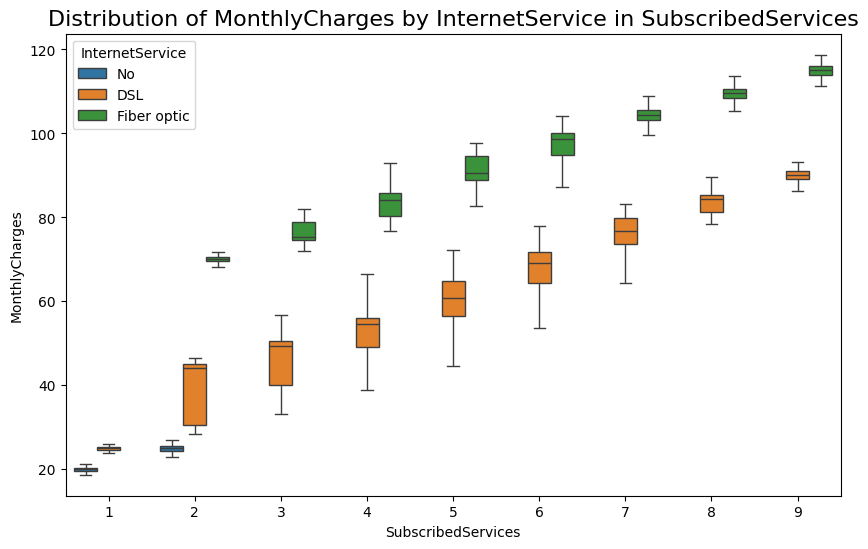

In [197]:
plot_boxplot('InternetService', df)

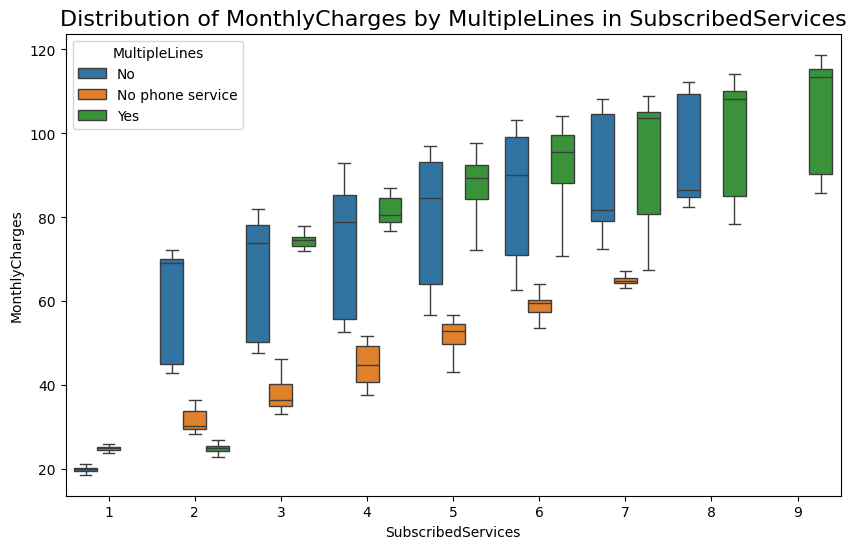

In [198]:
plot_boxplot('MultipleLines', df)

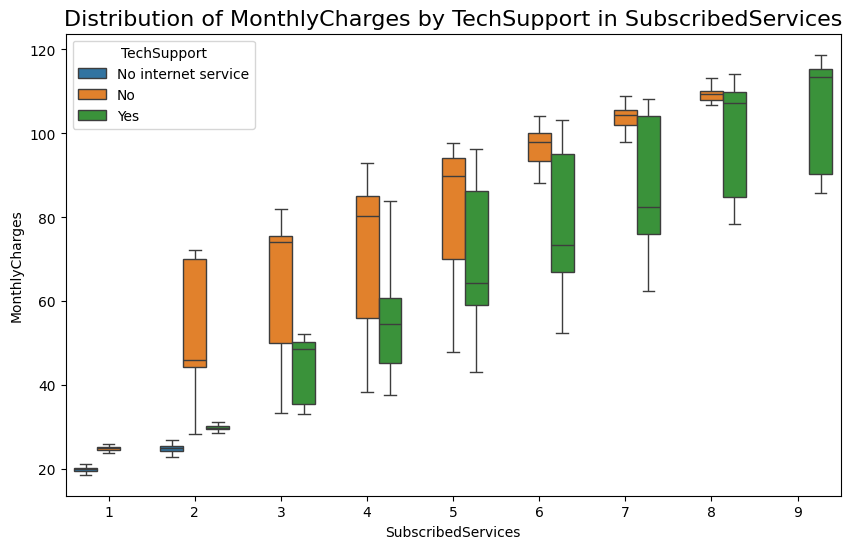

In [199]:
plot_boxplot('TechSupport', df)

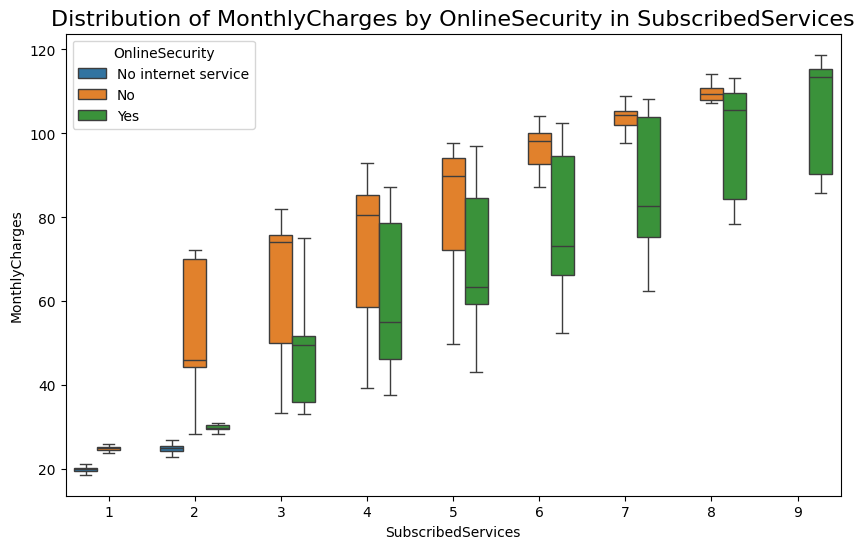

In [200]:
plot_boxplot('OnlineSecurity', df)

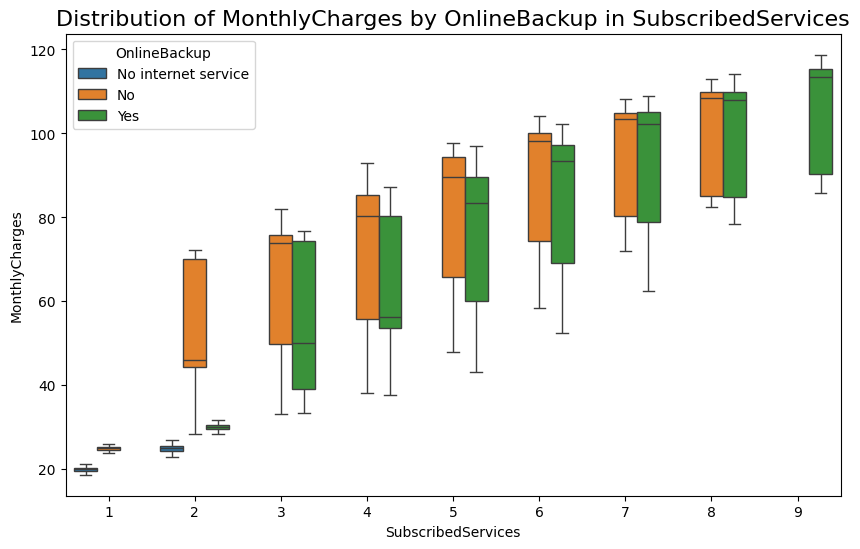

In [201]:
plot_boxplot('OnlineBackup', df)

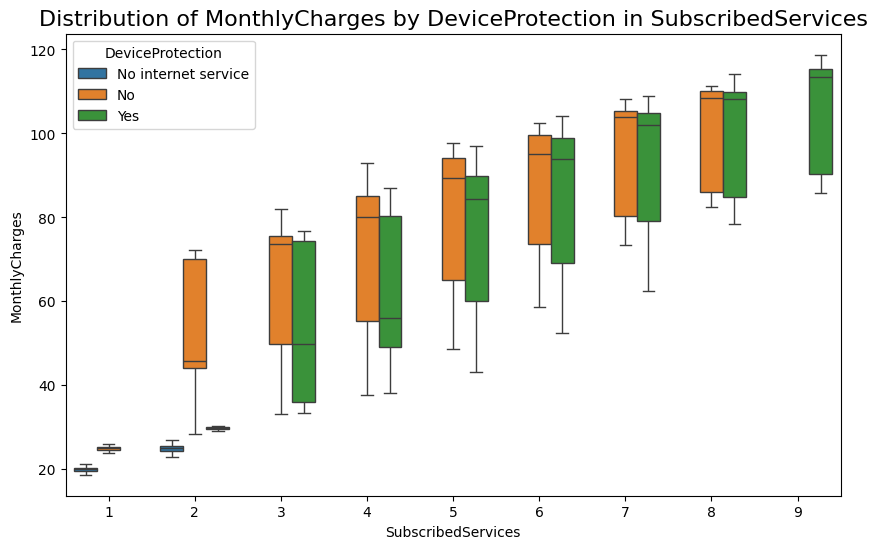

In [202]:
plot_boxplot('DeviceProtection', df)

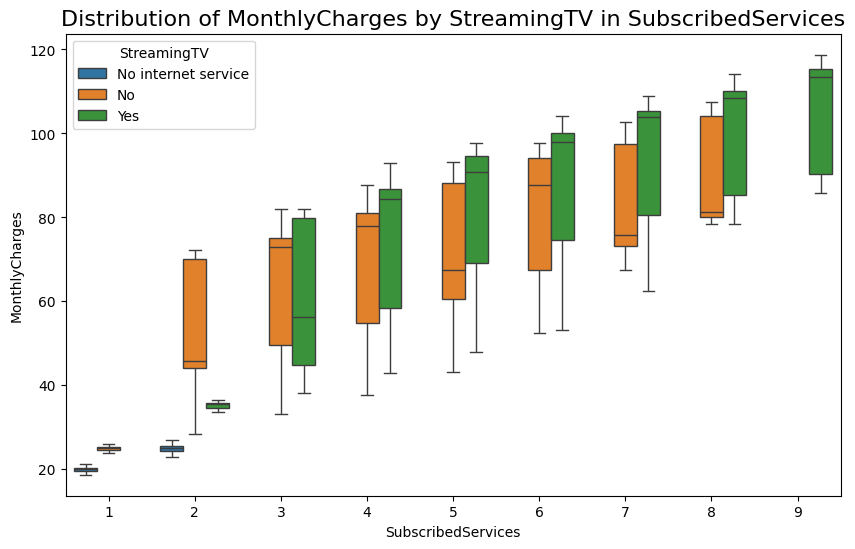

In [203]:
plot_boxplot('StreamingTV', df)

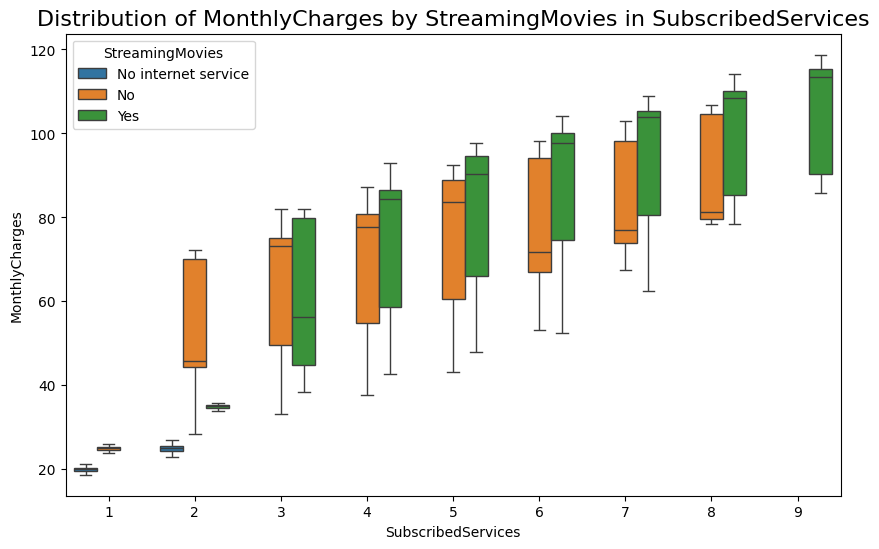

In [204]:
plot_boxplot('StreamingMovies', df)

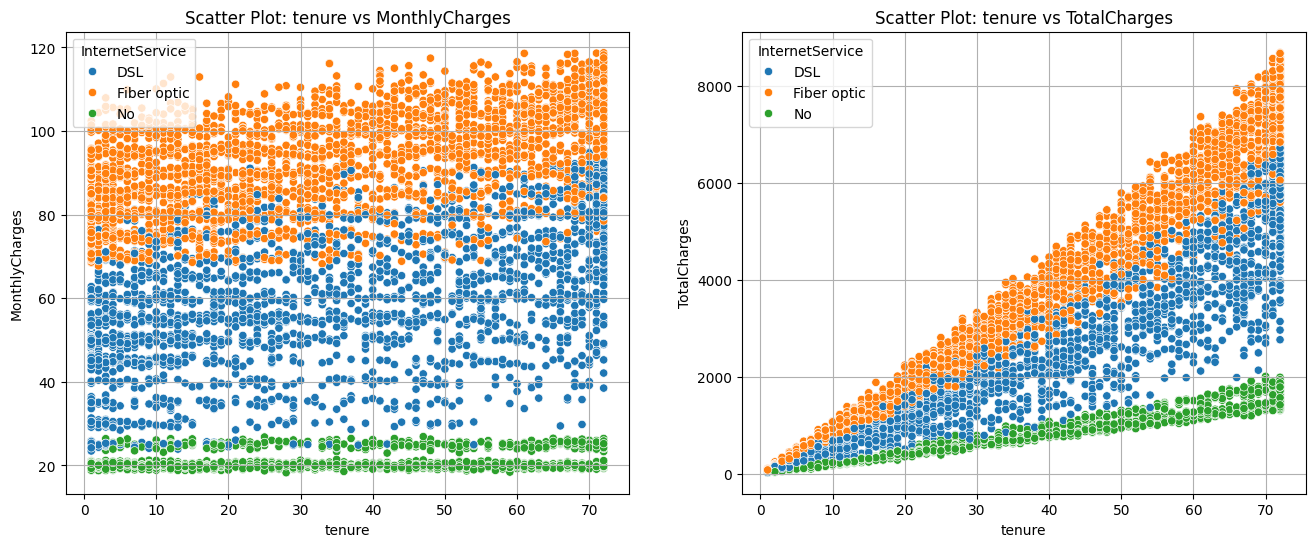

In [205]:
varTenure = 'tenure'
varMonthlyCharges = 'MonthlyCharges'
varTotalCharges = 'TotalCharges'
hue_var = 'InternetService'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# tenure vs MonthlyCharges
sns.scatterplot(data=df, x=varTenure, y=varMonthlyCharges, hue=hue_var, ax=axes[0])
axes[0].set_title('Scatter Plot: ' + varTenure + ' vs ' + varMonthlyCharges)
axes[0].set_xlabel(varTenure)
axes[0].set_ylabel(varMonthlyCharges)
axes[0].grid(True)

# tenure vs TotalCharges
sns.scatterplot(data=df, x=varTenure, y=varTotalCharges, hue=hue_var, ax=axes[1])
axes[1].set_title('Scatter Plot: ' + varTenure + ' vs ' + varTotalCharges)
axes[1].set_xlabel(varTenure)
axes[1].set_ylabel(varTotalCharges)
axes[1].grid(True)

**Observation**
1. `TechSupport`, `OnlineBackup`, `OnlineSecurity`, `DeviceProtection`, `StreamingTV`, `StreamingMovies` tend to have similar distribution in price, even though they correlate highly to churn rate, they do not specifically impact churn rates much.
2. Distribution on `InternetService` fiber optic is higher significantly compared to DSL.
3. Customer are willing to pay more the longer their tenure is.

**Summary**
1. `InternetService` fiber optic may be the reason for customer churn, and other services do not.
2. `InternetService` need further analysis.

#### **8.2 Is the price of `InternetService` fiber optic the reason for high churn rate?**

Text(0.5, 1.0, 'Internet Service vs Churn Rate (%)')

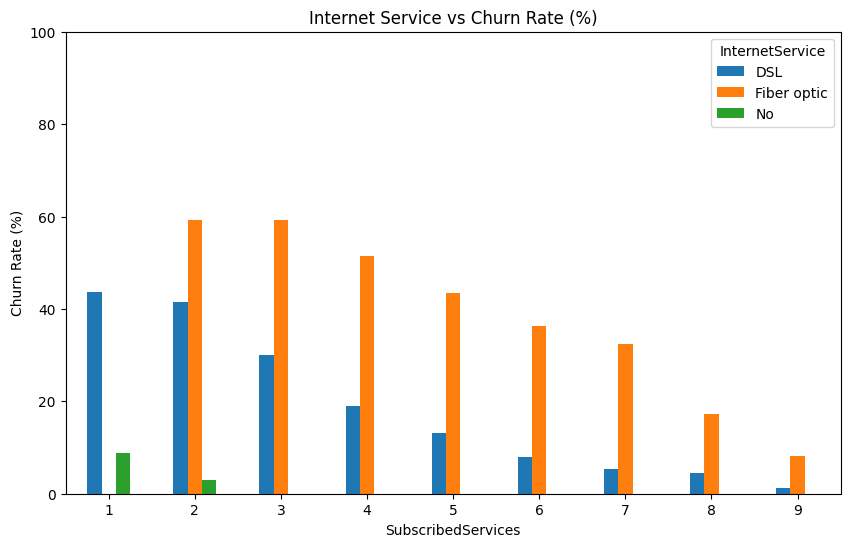

In [206]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='Churn', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.ylim(0,100)
plt.xticks(rotation=0)
plt.ylabel('Churn Rate (%)')
plt.title('Internet Service vs Churn Rate (%)')

Text(0.5, 1.0, 'Internet Service vs Monthly Charges')

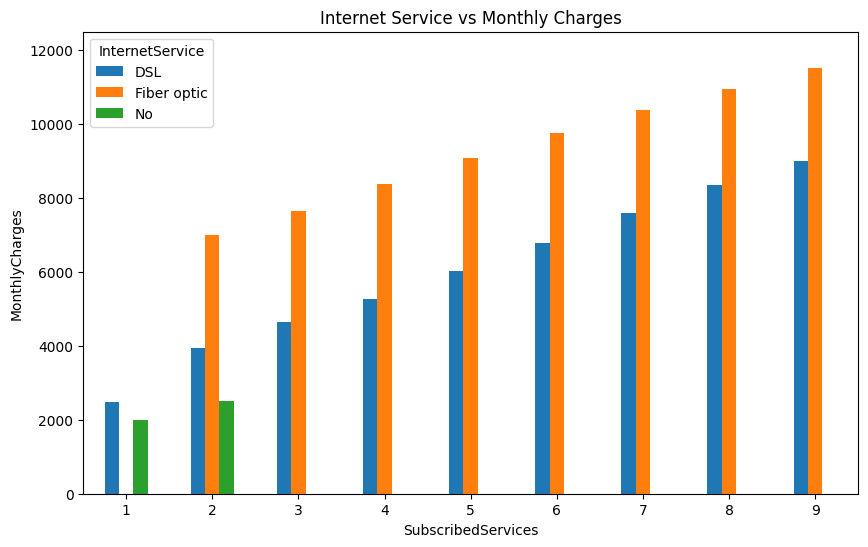

In [207]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='MonthlyCharges', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.ylim(0, 12500)
plt.xticks(rotation=0)
plt.ylabel('MonthlyCharges')
plt.title('Internet Service vs Monthly Charges')

Text(0.5, 1.0, 'Internet Service vs Total Charges')

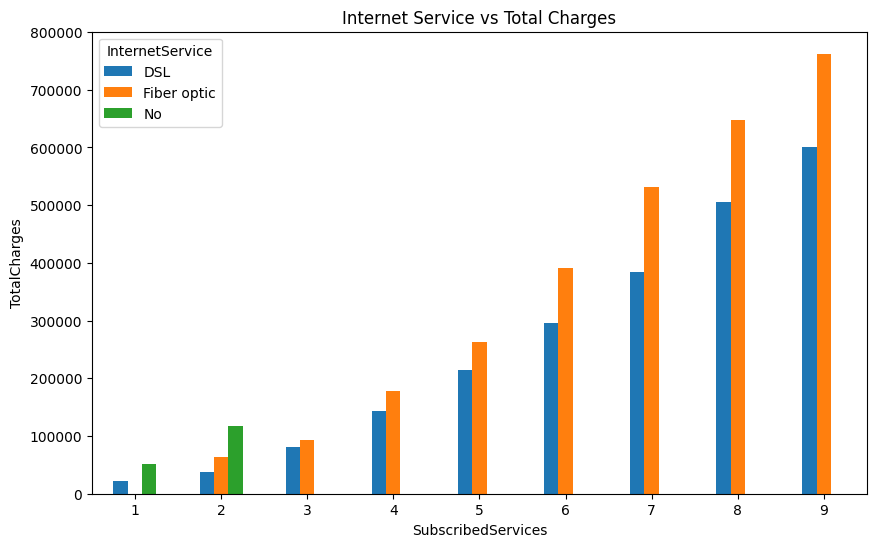

In [208]:
(pd.pivot_table(df, index='SubscribedServices', columns='InternetService', values='TotalCharges', aggfunc='mean')*100).plot(kind='bar', figsize=(10,6))
plt.xticks(rotation=0)
plt.ylabel('TotalCharges')
plt.title('Internet Service vs Total Charges')

**Observation :**<br/>
The difference on `Churn` rate is significant with approximately ~15-20% between DSL & Fiber Optic. Even though as customers subscribe to more services, the churn rate drops, but there is still a significant difference in churn rate. Also, based on `MonthlyCharges` and `TotalCharges`, even when adding more subscribed services, the price difference is still at a significance. Therefore:



**Summary**<br/>
Internet Service Fiber Optic price is the reason of high Churn rate.

#### **8.3. Do customers with higher `tenure` tend to choose longer-term `Contracts`, and how does this impact their churn rate?**

In [209]:
print(f'tenure unique :\n {df['tenure'].unique()}\n')
print(f'tenure min : {df['tenure'].unique().min()}\n')
print(f'tenure max : {df['tenure'].unique().max()}\n')

print(f'Contract : {df['Contract'].unique()}\n')

tenure unique :
 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

tenure min : 1

tenure max : 72

Contract : ['Month-to-month' 'One year' 'Two year']



**Observation**
1. Since contract is divided into 3 categories, ranging from `Month-to-Month`, `One year`, and `Two year`. It's best we engineer a new feature grouping the tenure based on the year.

In [210]:
def cat_tenure(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return 'Over 48 Months'

In [211]:
new_df['tenureCat'] = new_df['tenure'].apply(cat_tenure)

In [212]:
new_df['tenureCat'].unique()

array(['0-12 Months', '24-48 Months', '12-24 Months', 'Over 48 Months'],
      dtype=object)

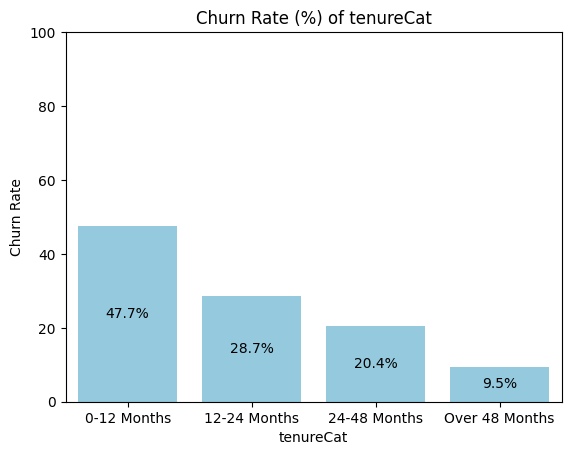

In [213]:
predictor_target(new_df, 'tenureCat')

In [214]:
check_dependency(new_df, 'tenureCat','Churn')

=== V1: tenureCat === V2: Churn ===
Chi-square Statistic : 864.0199735524177 
p-value: 5.638328081483389e-187 < 0.05 
V1 and V2 are dependent (significant association)



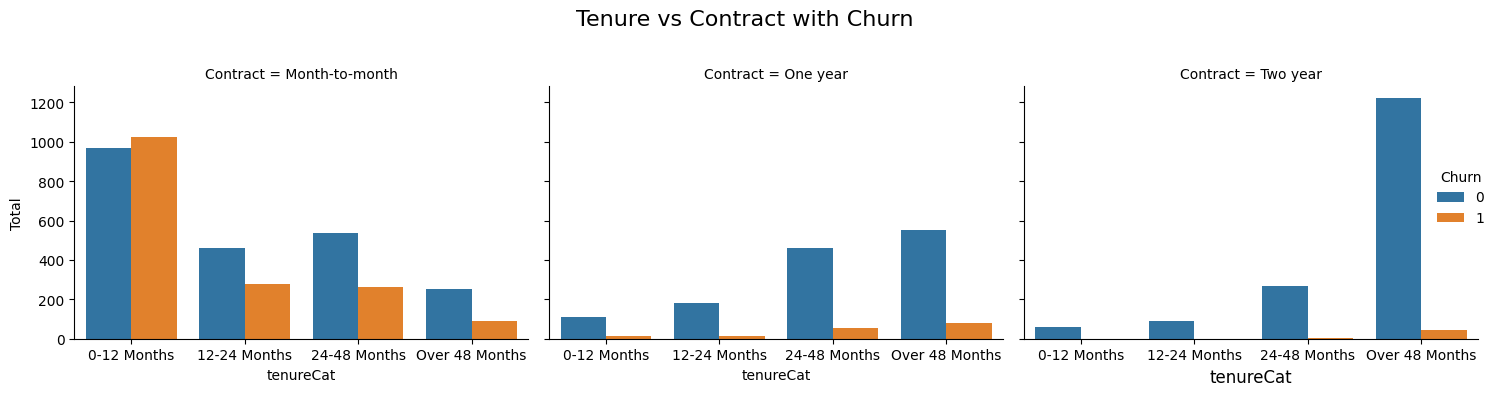

In [215]:
df_plot = pd.crosstab([new_df['tenureCat'], new_df['Churn']], new_df['Contract']).reset_index()

df_melt = df_plot.melt(id_vars=['tenureCat', 'Churn'], var_name='Contract', value_name='Total')

sns.catplot(data=df_melt, x='tenureCat', y='Total', hue='Churn', kind='bar', col='Contract', height=4, aspect=1.2)

plt.xticks(rotation=0)
plt.ylabel('Total', fontsize=12)
plt.xlabel('tenureCat', fontsize=12)
plt.suptitle('Tenure vs Contract with Churn', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [216]:
check_dependency(new_df, 'tenureCat','Contract')

=== V1: tenureCat === V2: Contract ===
Chi-square Statistic : 3160.39544920097 
p-value: 0.0 < 0.05 
V1 and V2 are dependent (significant association)



**Summary**
1. The more `tenure` a customer has, they tend to choose a longer-term contract and less likely to churn.
2. Customers with a tenure of <= 12 months (a year) tend to take a month-to-month `Contract`. This make sense due to previous findings that customers tend to churn significantly when they take a month-to-month `Contract`.

#### **8.4. What services do customer choose based on the length of their tenure?**

In [217]:
def tenure_sub_rate(x, y):
    if y == 'SubscribedServices':
        tenure_count = pd.crosstab(new_df[x], new_df[y]).unstack(level=1).reset_index()
    else:
        tenure_count = pd.crosstab(new_df[x], df[y]).unstack(level=1).reset_index()

    tenure_count.columns = [y, x, 'count']

    tenure_count_df = pd.DataFrame(tenure_count)

    total_customers = tenure_count_df.groupby(x)['count'].sum().reset_index()
    total_customers.columns = [x, 'Total']

    tenure_count_df = tenure_count_df.merge(total_customers, on=x)

    tenure_count_df['Percentage'] = (tenure_count_df['count'] / tenure_count_df['Total']) * 100

    # Pivot the dataframe for plotting
    df_pivot = tenure_count_df.pivot(index=x, columns=y, values='Percentage')

    if y == 'SubscribedServices':
        ax = df_pivot.plot(kind='bar', figsize=(18, 6), width=0.8)
        plt.ylim(0, 30)
        plt.title(f'{y}(%) by {x}')
    else:
        ax = df_pivot.plot(kind='bar', figsize=(10, 6), width=0.8)
        plt.ylim(0, 100)
        plt.title(f'{y} Types (%) by {x}')
    
    
    plt.xlabel(x)
    plt.ylabel('Percentage')
    plt.legend(title=x, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)

    # Add labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

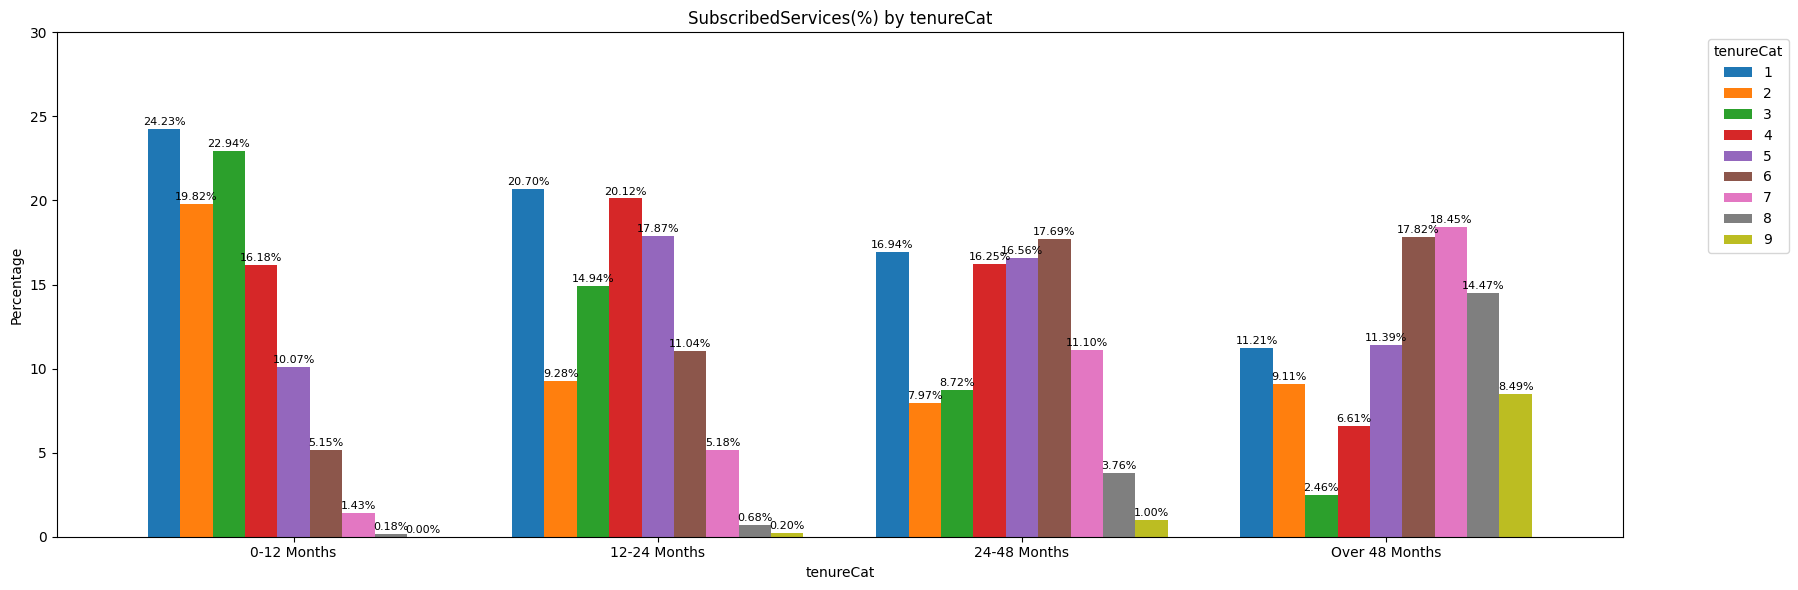

In [218]:
tenure_sub_rate('tenureCat', 'SubscribedServices')

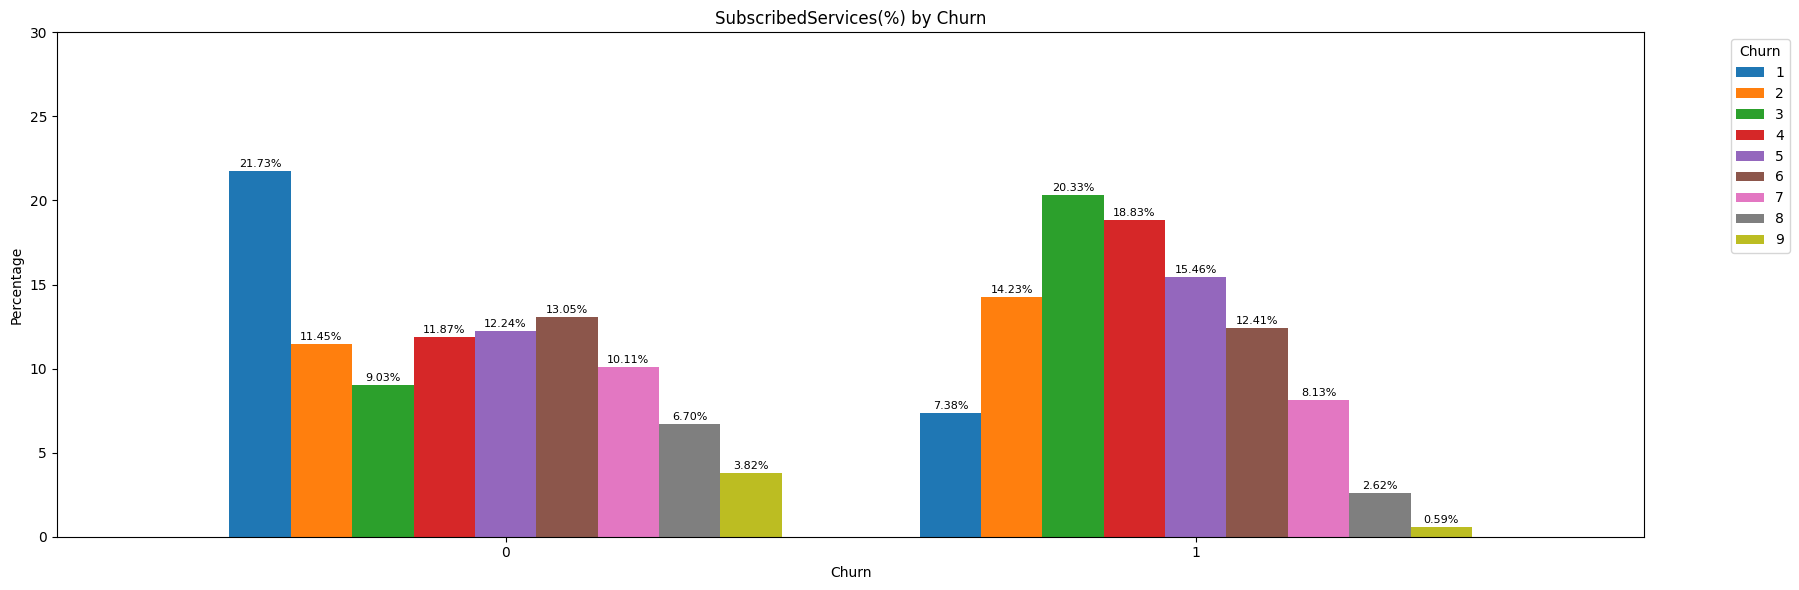

In [219]:
tenure_sub_rate('Churn', 'SubscribedServices')

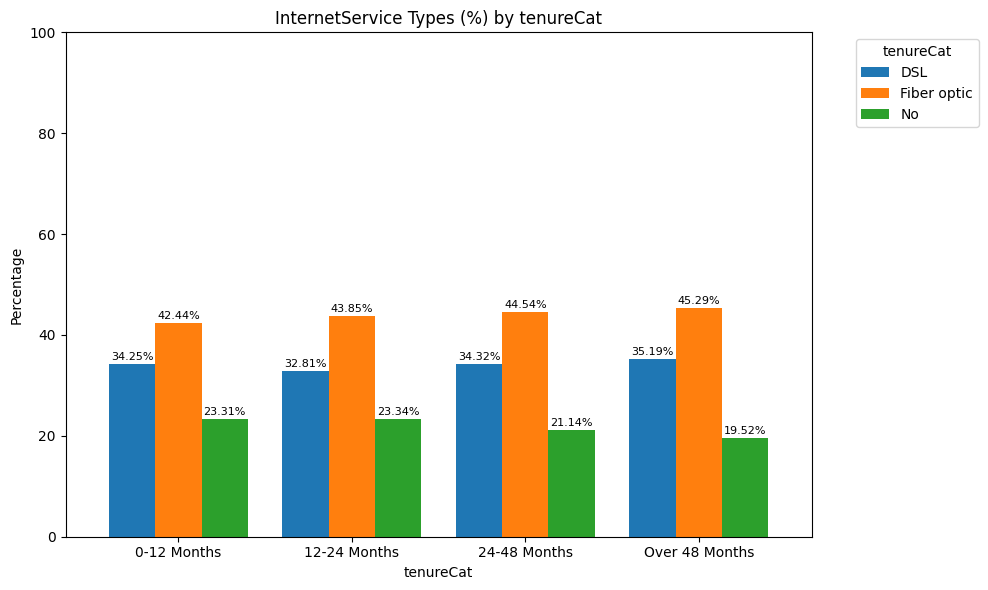

In [220]:
tenure_sub_rate('tenureCat', 'InternetService')

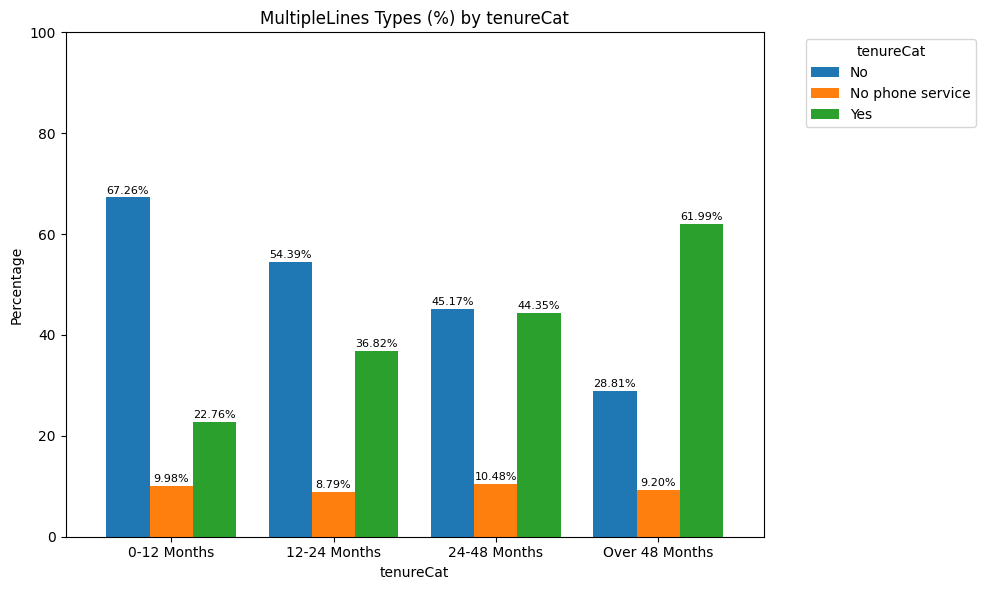

In [221]:
tenure_sub_rate('tenureCat', 'MultipleLines')

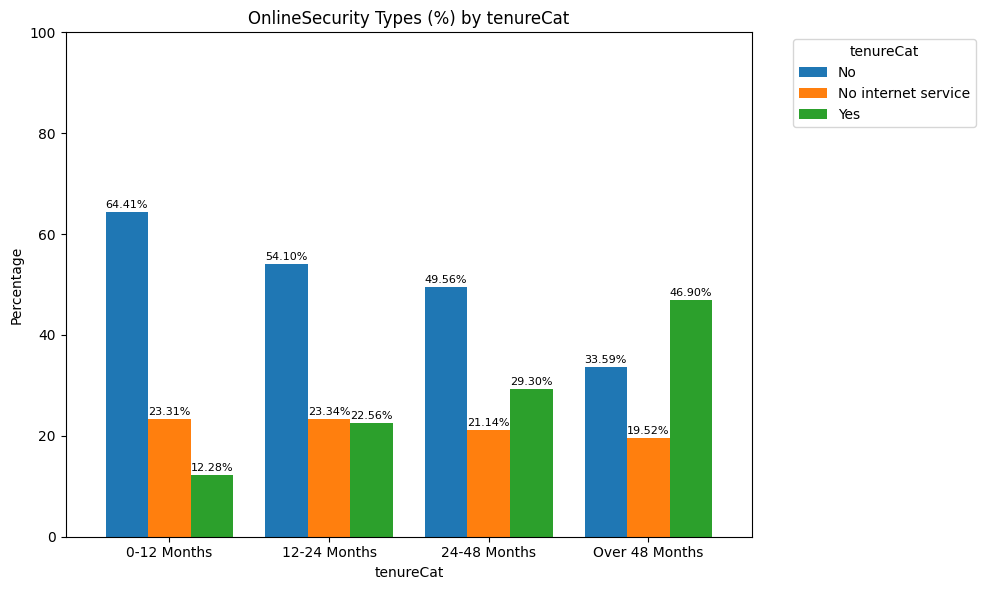

In [222]:
tenure_sub_rate('tenureCat', 'OnlineSecurity')

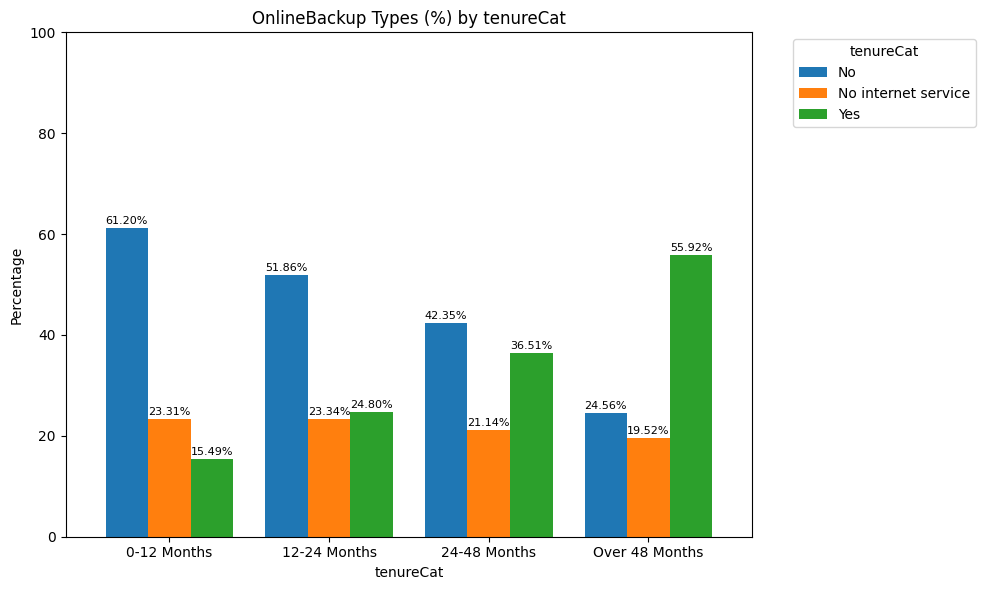

In [223]:
tenure_sub_rate('tenureCat', 'OnlineBackup')

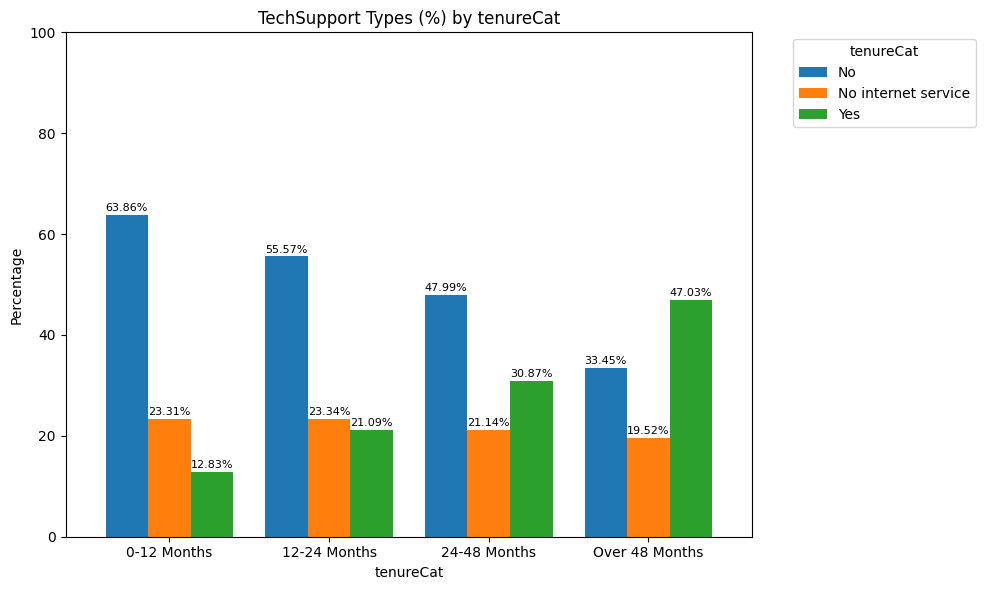

In [224]:
tenure_sub_rate('tenureCat', 'TechSupport')

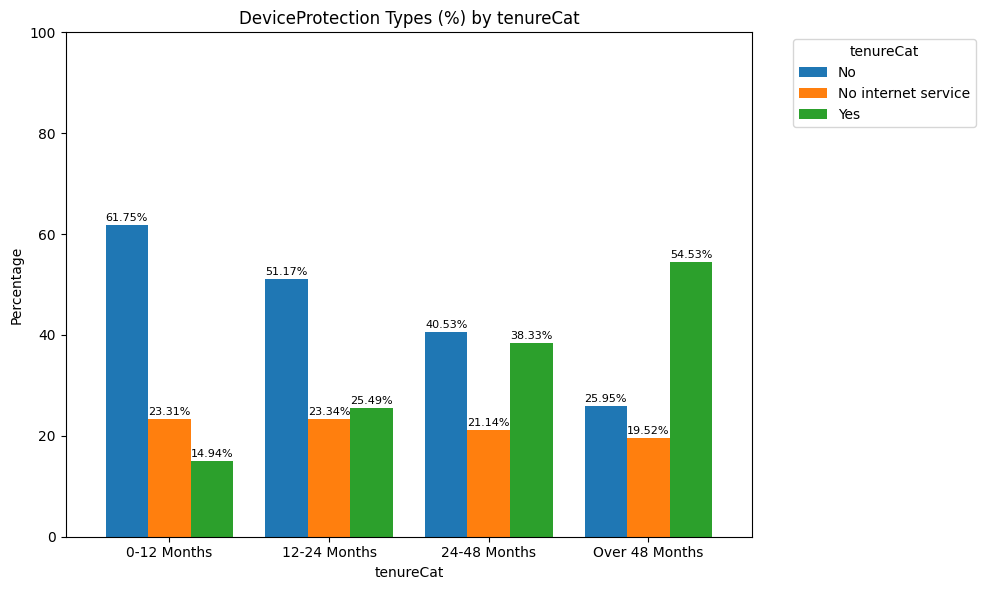

In [225]:
tenure_sub_rate('tenureCat', 'DeviceProtection')

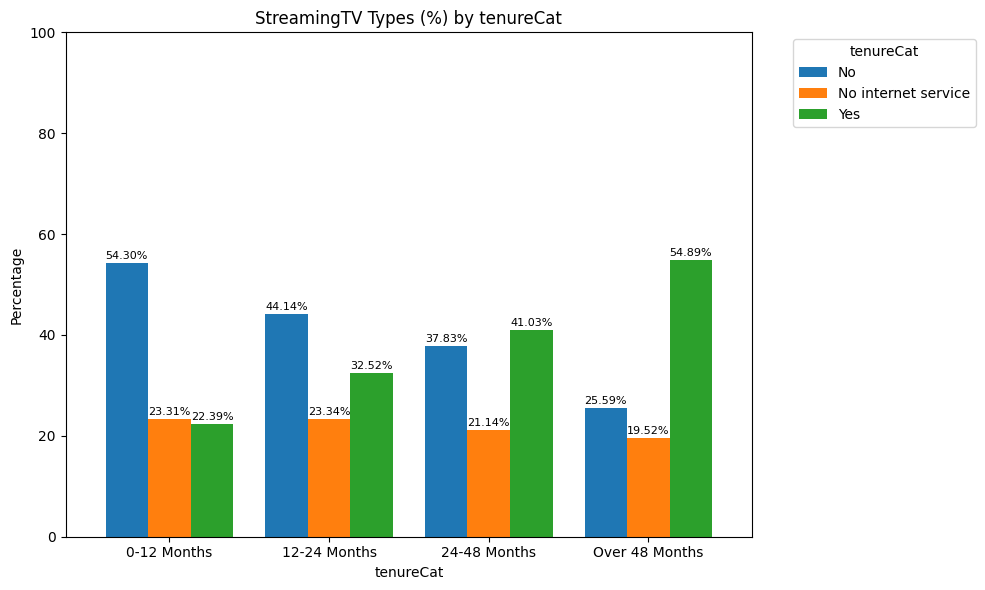

In [226]:
tenure_sub_rate('tenureCat', 'StreamingTV')

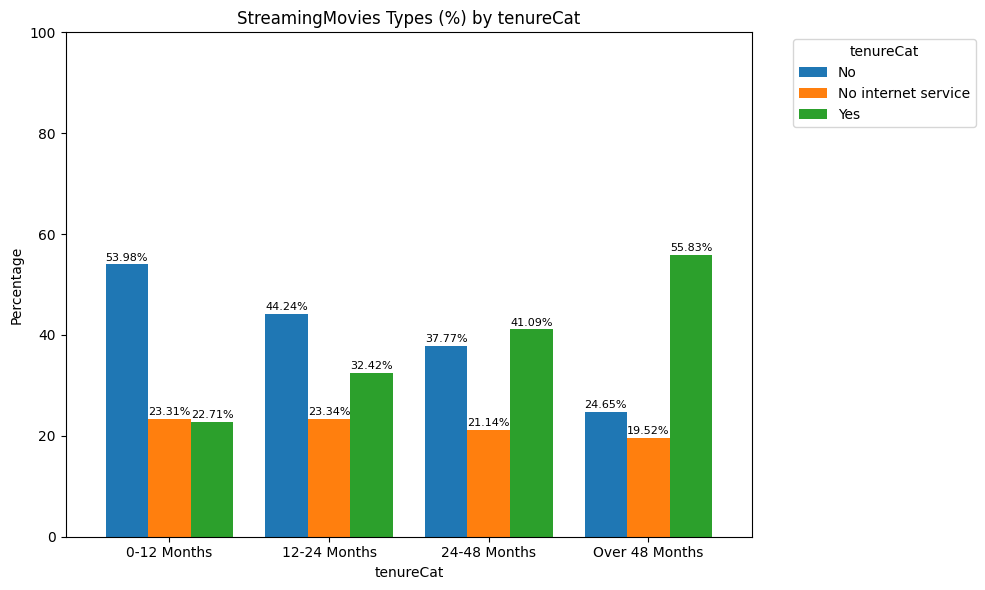

In [227]:
tenure_sub_rate('tenureCat', 'StreamingMovies')

In [228]:
dependentServices = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection']

In [229]:
for i in dependentServices:
    check_dependency(new_df, i, 'tenureCat')

=== V1: MultipleLines === V2: tenureCat ===
Chi-square Statistic : 711.8418178324586 
p-value: 5.678764950448439e-154 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: InternetService === V2: tenureCat ===
Chi-square Statistic : 11.511397435512244 
p-value: 0.009258848147383468 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineSecurity === V2: tenureCat ===
Chi-square Statistic : 668.761928814464 
p-value: 1.2457075228757717e-144 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: OnlineBackup === V2: tenureCat ===
Chi-square Statistic : 847.8042158090515 
p-value: 1.8546111738494237e-183 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: StreamingMovies === V2: tenureCat ===
Chi-square Statistic : 531.3489733188973 
p-value: 7.664458799290879e-115 < 0.05 
V1 and V2 are dependent (significant association)

=== V1: StreamingTV === V2: tenureCat ===
Chi-square Statistic : 512.4921302601708 
p-value: 9.362169872284552e

**Observation**
1. The number of services customer subscribes to increases as the tenure increase.
2. Users tend to churn when they subscribe to 2-5 services.

How many services do customers subscribe to based on tenure?
1. 0-12 Months : 1 service
2. 12-24 Months : 1-2 services
3. 24-48 Months : 1 service or 4-6 services
4. Over 48 Months : 6-8 services

What do customers tend to subscribe to based on tenure excluding `PhoneService`?
1. 0-12 Months : Fiber Optic
2. 12-24 Months : Fiber Optic, Multiple Lines
3. 24-48 Months : Fiber Optic, Multiple Lines, StreamingTV, StreamingMovies, Device Protection, OnlineBackup
4. Over 48 Months : Fiber Optic, Multiple Lines, StreamingTV, StreamingMovies, Device Protection, OnlineBackup, OnlineSecurity, TechSupport

## **Data Preprocessing (Modelling)**

### **1. Feature Selection**

In [230]:
data_info(df_ori)

Rows,Columns (7032, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
customerID,0,0.0,object,7032
DeviceProtection,0,0.0,object,3
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


Based on **Exploratory Data Analysis** above, we know that `gender` and `PhoneService` do not influence `Churn` rate. Therefore we drop the two columns so that it doesn't influence our model. We also remove `customerID` since there's too much unique data and it doesn't effect `Churn` and the model might be overfitting.

In [231]:
df_model = df_ori.copy()

In [232]:
df_model.drop(
    ['customerID', 'gender', 'PhoneService'], axis=1, inplace=True)

In [233]:
data_info(df_model)

Rows,Columns (7032, 18)
Duplicated Values 41
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int64,2
Partner,0,0.0,object,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


In [234]:
# There are 41 duplicates, which is 0.5% of the total data so it's fine if we remove the rows and keep the first
df_model.drop_duplicates(keep = 'first', inplace = True)

In [235]:
data_info(df_model)

Rows,Columns (6991, 18)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int64,2
Partner,0,0.0,object,2
TotalCharges,0,0.0,float64,6530
MonthlyCharges,0,0.0,float64,1584
PaymentMethod,0,0.0,object,4
PaperlessBilling,0,0.0,object,2
Contract,0,0.0,object,3
StreamingMovies,0,0.0,object,3
StreamingTV,0,0.0,object,3
TechSupport,0,0.0,object,3


**Note :**
1. Deleting **duplicates** is necessary so that the model that we want to train is not bias to a certain result.

In [236]:
df_model.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### **2. Label Encoding**

In [237]:
# Replace 'No' with 0 and 'Yes' with 1 in the 'Partner' column
df_model['Partner'] = df_model['Partner'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0 and 'Yes' with 1 in the 'Dependents' column
df_model['Dependents'] = df_model['Dependents'].replace(['No' ,'Yes'],[0,1])

# Replace 'No' with 0, 'Yes' with 1, and 'No phone service' with 0 in the 'MultipleLines' column
df_model['MultipleLines'] = df_model['MultipleLines'].replace(['No' ,'Yes', 'No phone service'],[0, 1, 0])

# Replace 'No' with 0, 'Fiber optic' with 1, and 'DSL' with 0 in the 'InternetService' column
df_model['InternetService'] = df_model['InternetService'].replace({'No': 0, 'Fiber optic': 2, 'DSL': 1})

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineSecurity' column
df_model['OnlineSecurity'] = df_model['OnlineSecurity'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'OnlineBackup' column
df_model['OnlineBackup'] = df_model['OnlineBackup'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'DeviceProtection' column
df_model['DeviceProtection'] = df_model['DeviceProtection'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'TechSupport' column
df_model['TechSupport'] = df_model['TechSupport'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingTV' column
df_model['StreamingTV'] = df_model['StreamingTV'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'StreamingMovies' column
df_model['StreamingMovies'] = df_model['StreamingMovies'].replace(['No' ,'Yes', 'No internet service'],[0, 1, 0])

# Replace 'No' with 0, 'Yes' with 1, and 'No internet service' with 0 in the 'PaperlessBilling' column
df_model['PaperlessBilling'] = df_model['PaperlessBilling'].replace(['No' ,'Yes'],[0, 1])


### **3. Ordinal Encoding**

In [238]:
Contract_dict = {
    'Month-to-month' : 0,
    'One year' : 1,
    'Two year' : 2}

df_model['Contract'] = df_model['Contract'].map(Contract_dict)

### **4. One-Hot Encoding**

In [239]:
df_model = pd.get_dummies(df_model, columns=['PaymentMethod']).astype(int)

In [240]:
df_model.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,1,0,0,...,0,0,1,29,29,0,0,0,1,0
1,0,0,0,34,0,1,1,0,1,0,...,0,1,0,56,1889,0,0,0,0,1
2,0,0,0,2,0,1,1,1,0,0,...,0,0,1,53,108,1,0,0,0,1
3,0,0,0,45,0,1,1,0,1,1,...,0,1,0,42,1840,0,1,0,0,0
4,0,0,0,2,0,2,0,0,0,0,...,0,0,1,70,151,1,0,0,1,0


In [241]:
data_info(df_model)

Rows,Columns (6991, 21)
Duplicated Values 167
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int32,2
StreamingMovies,0,0.0,int32,2
PaymentMethod_Electronic check,0,0.0,int32,2
PaymentMethod_Credit card (automatic),0,0.0,int32,2
PaymentMethod_Bank transfer (automatic),0,0.0,int32,2
Churn,0,0.0,int32,2
TotalCharges,0,0.0,int32,3846
MonthlyCharges,0,0.0,int32,99
PaperlessBilling,0,0.0,int32,2
Contract,0,0.0,int32,3


In [242]:
# There are 167 duplicates, which is 2.3% of the total data after encoding (6991) so it's fine if we remove the rows and keep the first
df_model.drop_duplicates(keep = 'first', inplace = True)

In [243]:
data_info(df_model)

Rows,Columns (6824, 21)
Duplicated Values 0
=====



,missingValue,percentMissing,DataType,Unique
SeniorCitizen,0,0.0,int32,2
StreamingMovies,0,0.0,int32,2
PaymentMethod_Electronic check,0,0.0,int32,2
PaymentMethod_Credit card (automatic),0,0.0,int32,2
PaymentMethod_Bank transfer (automatic),0,0.0,int32,2
Churn,0,0.0,int32,2
TotalCharges,0,0.0,int32,3846
MonthlyCharges,0,0.0,int32,99
PaperlessBilling,0,0.0,int32,2
Contract,0,0.0,int32,3


### **5. Data Sampling**

In [244]:
df_model['Churn'].value_counts()

Churn
0    5069
1    1755
Name: count, dtype: int64

In [245]:
df_model['Churn'].value_counts(normalize=True)

Churn
0    0.742819
1    0.257181
Name: proportion, dtype: float64

In [246]:
# feature
X = df_model.drop(['Churn'],axis=1)

# target
y = df_model['Churn']

We use oversampling method to populate the Churn rate

In [247]:
X_over_smote, y_over_smote = SMOTE().fit_resample(X, y)

In [248]:
# first split: pretrain & test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X_over_smote, y_over_smote, test_size=0.2, random_state=42)

# second split: train & validation
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)

### **6. Feature Transformation**

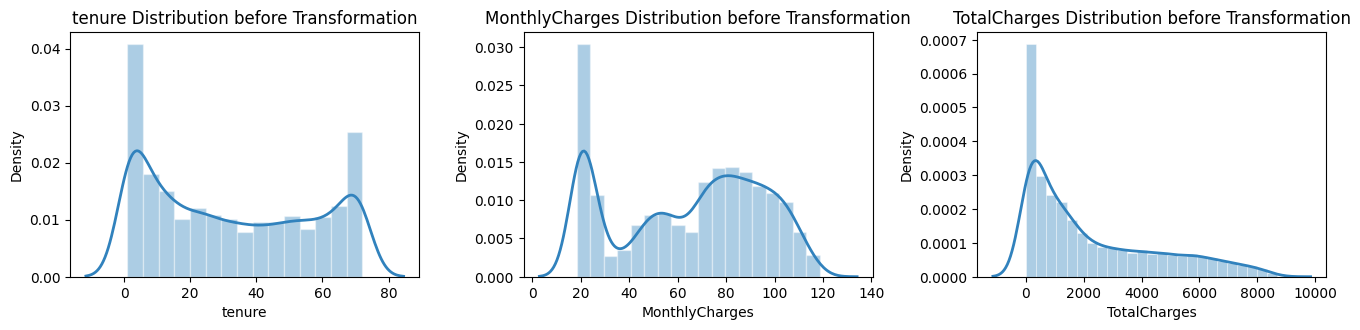

In [249]:
plt.figure(figsize=(18,6))
for i in range(0, len(customerSpending)):
  plt.subplot(2, 4, i+1)

  sns.histplot(x=df[customerSpending[i]], hue = i, palette = "tab20c", 
               legend=False, kde=True, stat="density", line_kws={'linewidth': 2}, 
               kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
  
  plt.title(f'{customerSpending[i]} Distribution before Transformation')
  plt.xlabel(customerSpending[i])
  plt.tight_layout()

`tenure` and `MonthlyCharges` are evenly distributed, `TotalCharges` on the other hand is positively skewed.

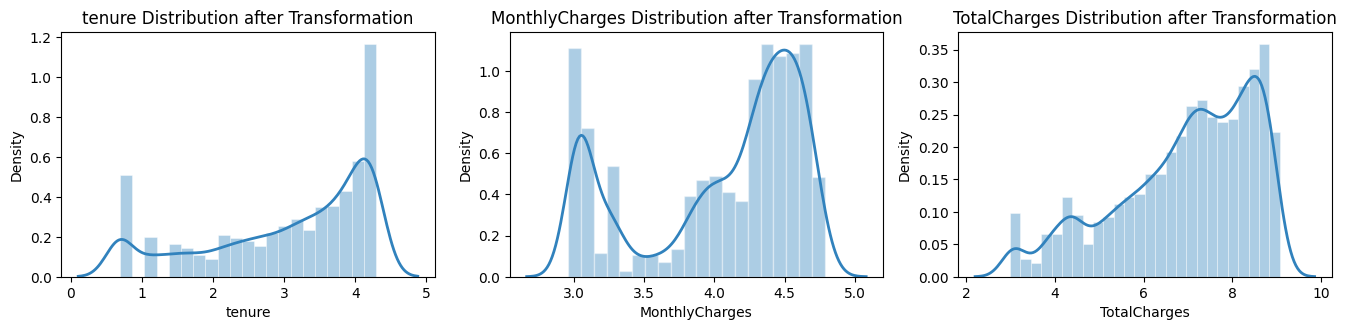

In [250]:
plt.figure(figsize=(18,6))
for i in range(0, len(customerSpending)):
  plt.subplot(2, 4, i+1)

  sns.histplot(x=np.log1p(df[customerSpending[i]]), hue = i, palette = "tab20c", 
               legend=False, kde=True, stat="density", line_kws={'linewidth': 2}, 
               kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
  
  plt.title(f'{customerSpending[i]} Distribution after Transformation')
  plt.xlabel(customerSpending[i])
  plt.tight_layout()

log1p is chosen due to the fact `TotalCharges` has wide data spread. For `tenure` and `MonthlyCharges` we use non transformed data since after transformation the distribution is similar.

In [251]:
X_train['TotalCharges'] = np.log1p(X_train['TotalCharges'])
X_val['TotalCharges'] = np.log1p(X_val['TotalCharges'])
X_test['TotalCharges'] = np.log1p(X_test['TotalCharges'])

### **7. Feature Scalling**

In [252]:
scaler = preprocessing.StandardScaler()

In [253]:
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.fit_transform(X_val)
X_test_std = scaler.fit_transform(X_test)

In [254]:
X_train.head()


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
9443,0,0,0,53,1,1,1,0,1,0,0,1,0,0,99,8.583917,0,1,0,0
4211,0,0,0,2,0,2,0,0,0,0,0,0,0,1,70,4.820282,0,0,1,0
1376,1,0,0,4,0,2,0,1,1,0,1,1,0,1,99,6.093570,0,1,0,0
2477,0,0,0,9,1,2,0,0,0,0,0,1,0,1,83,6.689599,0,0,1,0
9369,0,0,0,8,1,2,0,0,0,0,1,1,0,0,96,6.658011,0,0,0,0


In [255]:
y_train.head()

9443    1
4211    0
1376    1
2477    1
9369    1
Name: Churn, dtype: int32

## **Modelling**

### **1. Logistic Regression**

In [256]:
logreg = LogisticRegression(random_state=42)

In [257]:
param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20)
    }
]

logreg_clf_gridcv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_clf_gridcv.fit(X_val_std, y_val)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2', 'elasticnet', 'none']}],
             scoring='recall')

In [258]:
hp_results(logreg_clf_gridcv)

Best Params: {'C': 0.0018329807108324356, 'penalty': 'l2'}



,params,mean_test_score,rank_test_score
0,"{'C': 0.0001, 'penalty': 'l1'}",NaN,21
1,"{'C': 0.0001, 'penalty': 'l2'}",0.626741,20
2,"{'C': 0.0001, 'penalty': 'elasticnet'}",NaN,21
3,"{'C': 0.0001, 'penalty': 'none'}",NaN,21
4,"{'C': 0.00026366508987303583, 'penalty': 'l1'}",NaN,21
5,"{'C': 0.00026366508987303583, 'penalty': 'l2'}",0.813358,19
6,"{'C': 0.00026366508987303583, 'penalty': 'elas...",NaN,21
7,"{'C': 0.00026366508987303583, 'penalty': 'none'}",NaN,21
8,"{'C': 0.0006951927961775605, 'penalty': 'l1'}",NaN,21
9,"{'C': 0.0006951927961775605, 'penalty': 'l2'}",0.850711,3


ACCURACY: 0.8477	PRECISION: 0.8288	RECALL: 0.8597	F1 SCORE: 0.8440	ROC SCORE: 0.9294

 Average recall score: 0.8409


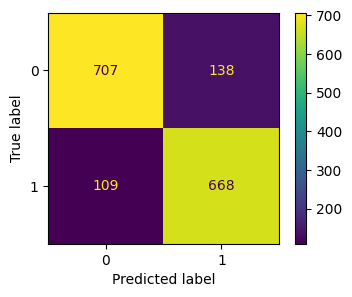

In [259]:
eval_model(X_train_std, y_train, X_val_std, y_val, logreg, True)

ACCURACY: 0.8212	PRECISION: 0.7796	RECALL: 0.8739	F1 SCORE: 0.8240	ROC SCORE: 0.9112

 Average recall score: 0.8583


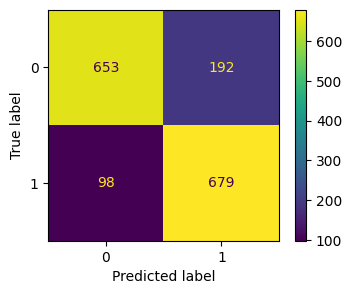

In [260]:
eval_model(X_train_std, y_train, X_val_std, y_val, logreg_clf_gridcv.best_estimator_, True)

Based on training model & validation model (after hyperparameter tuning) we can see that the recall score after hyperparameter tuning is higher by ~0.2%. Eventhough the accuracy is lower but it managed to recall higher. Both models after cross validation also puts out consistent results. This indicates it is optimum to tune hyperparameters to maximize recall score in this dataset.

ACCURACY: 0.8304	PRECISION: 0.8062	RECALL: 0.8712	F1 SCORE: 0.8374	ROC SCORE: 0.9022



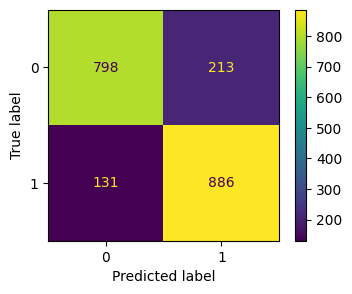

In [261]:
eval_model(X_train_std, y_train, X_test_std, y_test, logreg_clf_gridcv.best_estimator_)

The test results align well with the validation data, indicating that the model is neither underfitting nor overfitting.

### **2. K-Nearest Neighbor**

In [262]:
knn = KNeighborsClassifier()

In [263]:
parameters = {
    'n_neighbors': (2,3,4,5,6,7,8),
    'weights':('uniform','distance')
}

knn_clf_gridcv = GridSearchCV(knn, parameters, cv=5, scoring='recall')
knn_clf_gridcv.fit(X_val_std, y_val)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8),
                         'weights': ('uniform', 'distance')},
             scoring='recall')

In [264]:
hp_results(knn_clf_gridcv)

Best Params: {'n_neighbors': 7, 'weights': 'uniform'}



,params,mean_test_score,rank_test_score
0,"{'n_neighbors': 2, 'weights': 'uniform'}",0.671853,14
1,"{'n_neighbors': 2, 'weights': 'distance'}",0.808296,11
2,"{'n_neighbors': 3, 'weights': 'uniform'}",0.818602,9
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.825029,7
4,"{'n_neighbors': 4, 'weights': 'uniform'}",0.760662,13
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.823747,8
6,"{'n_neighbors': 5, 'weights': 'uniform'}",0.839165,3
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.832730,6
8,"{'n_neighbors': 6, 'weights': 'uniform'}",0.785103,12
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.837883,4


ACCURACY: 0.8187	PRECISION: 0.7934	RECALL: 0.8404	F1 SCORE: 0.8163	ROC SCORE: 0.8958

 Average recall score: 0.8250


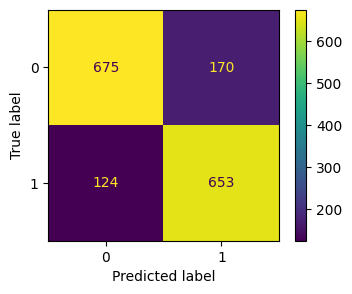

In [265]:
eval_model(X_train_std, y_train, X_val_std, y_val, knn, True)

ACCURACY: 0.8243	PRECISION: 0.7978	RECALL: 0.8481	F1 SCORE: 0.8222	ROC SCORE: 0.9089

 Average recall score: 0.8357


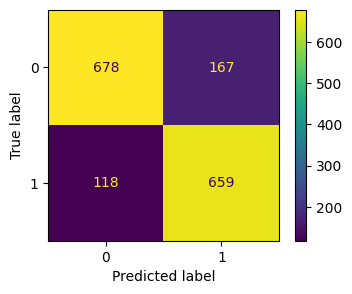

In [266]:
eval_model(X_train_std, y_train, X_val_std, y_val, knn_clf_gridcv.best_estimator_, True)

Based on training model & validation model (after hyperparameter tuning) we can see that the recall score after hyperparameter tuning is higher by ~0.8%. Both models put out a fair average recall score which indicates it is consistent in predicting via training data. The one without hyperparameter tuning results in a lower percentage difference. This indicates it is optimum to tune hyperparameters to maximize recall score in this dataset.

ACCURACY: 0.8294	PRECISION: 0.8180	RECALL: 0.8486	F1 SCORE: 0.8330	ROC SCORE: 0.8950



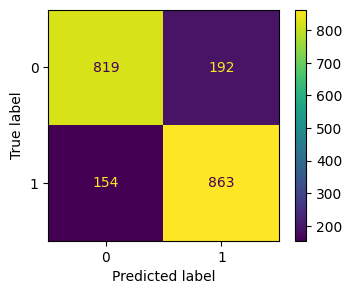

In [267]:
eval_model(X_train_std, y_train, X_test_std, y_test, knn_clf_gridcv.best_estimator_)

The test results align well with the validation data, indicating that the model is neither underfitting nor overfitting.

### **3. Decision Tree**

In [268]:
dt = DecisionTreeClassifier(random_state=42)

In [269]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20],
}

dt_clf_gridcv = GridSearchCV(dt, parameters, cv=5, scoring='recall')
dt_clf_gridcv.fit(X_val_std, y_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20]},
             scoring='recall')

In [270]:
hp_results(dt_clf_gridcv)

Best Params: {'criterion': 'gini', 'max_depth': 7}



,params,mean_test_score,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 4}",0.824971,9
1,"{'criterion': 'gini', 'max_depth': 5}",0.842961,3
2,"{'criterion': 'gini', 'max_depth': 6}",0.831381,5
3,"{'criterion': 'gini', 'max_depth': 7}",0.857113,1
4,"{'criterion': 'gini', 'max_depth': 8}",0.828842,8
5,"{'criterion': 'gini', 'max_depth': 9}",0.809578,11
6,"{'criterion': 'gini', 'max_depth': 10}",0.814673,10
7,"{'criterion': 'gini', 'max_depth': 15}",0.763226,17
8,"{'criterion': 'gini', 'max_depth': 20}",0.751646,18
9,"{'criterion': 'entropy', 'max_depth': 4}",0.801869,14


ACCURACY: 0.7916	PRECISION: 0.7661	RECALL: 0.8134	F1 SCORE: 0.7890	ROC SCORE: 0.7941

 Average recall score: 0.8116


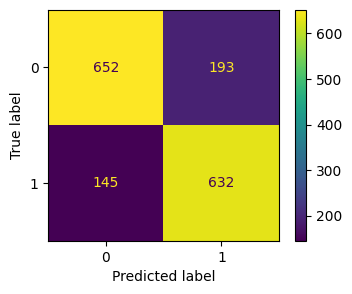

In [271]:
eval_model(X_train_std, y_train, X_val_std, y_val, dt, True)

ACCURACY: 0.8046	PRECISION: 0.7771	RECALL: 0.8301	F1 SCORE: 0.8027	ROC SCORE: 0.8880

 Average recall score: 0.8275


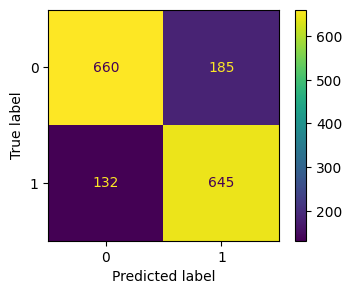

In [272]:
eval_model(X_train_std, y_train, X_val_std, y_val, dt_clf_gridcv.best_estimator_, True)

Based on training model & validation model (after hyperparameter tuning) we can see that the recall score after hyperparameter tuning is higher by ~2%. But both models put out a relatively similar average recall score during cross validation. The one with hyperparameter tuning results in a higher percentage difference.  This indicates it is optimum to tune hyperparameters to maximize recall score in this dataset.

ACCURACY: 0.8111	PRECISION: 0.8036	RECALL: 0.8250	F1 SCORE: 0.8142	ROC SCORE: 0.8884



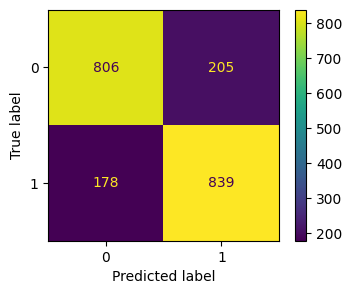

In [273]:
eval_model(X_train_std, y_train, X_test_std, y_test, dt_clf_gridcv.best_estimator_)

The test results align well with the validation data, indicating that the model is neither underfitting nor overfitting.

### **4. Random Forest**

In [274]:
rf = RandomForestClassifier(random_state=42)

In [275]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 3, 5],
}

rf_clf_gridcv = GridSearchCV(rf, parameters, cv=5, scoring='recall')
rf_clf_gridcv.fit(X_val_std, y_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 3, 5],
                         'n_estimators': [100, 150, 200]},
             scoring='recall')

In [276]:
hp_results(rf_clf_gridcv)

Best Params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}



,params,mean_test_score,rank_test_score
0,"{'criterion': 'gini', 'max_depth': None, 'n_es...",0.836526,24
1,"{'criterion': 'gini', 'max_depth': None, 'n_es...",0.842953,23
2,"{'criterion': 'gini', 'max_depth': None, 'n_es...",0.844260,22
3,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.867444,16
4,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.866154,18
5,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.871307,11
6,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.880323,4
7,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.884194,2
8,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.885484,1
9,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.870017,14


ACCURACY: 0.8434	PRECISION: 0.8232	RECALL: 0.8571	F1 SCORE: 0.8398	ROC SCORE: 0.9261

 Average recall score: 0.8412


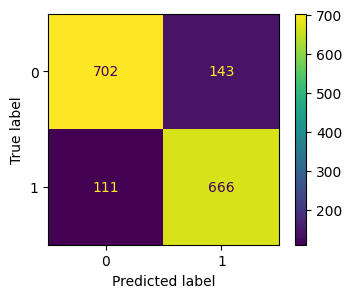

In [277]:
eval_model(X_train_std, y_train, X_val_std, y_val, rf, True)

ACCURACY: 0.8181	PRECISION: 0.7597	RECALL: 0.9073	F1 SCORE: 0.8270	ROC SCORE: 0.8922

 Average recall score: 0.8742


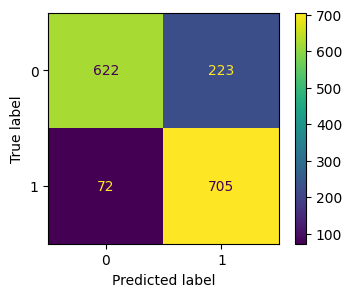

In [278]:
eval_model(X_train_std, y_train, X_val_std, y_val, rf_clf_gridcv.best_estimator_, True)

Based on training model & validation model (after hyperparameter tuning) we can see that the recall score after hyperparameter tuning is higher by ~5%. Although average recall score during cross validation, the one that is more consistent is the one with default hyperparameters. This indicates it is optimum to tune hyperparameters on Random Forest model to maximize recall score in this dataset.

ACCURACY: 0.8181	PRECISION: 0.7597	RECALL: 0.9073	F1 SCORE: 0.8270	ROC SCORE: 0.8922



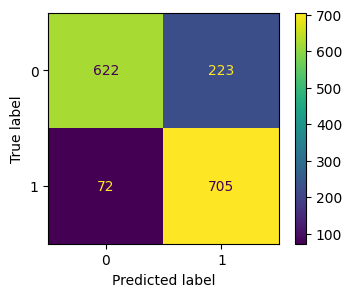

In [279]:
eval_model(X_train_std, y_train, X_val_std, y_val, rf_clf_gridcv.best_estimator_)

### **5. Naive Bayes**

In [280]:
nb = GaussianNB()

In [281]:
parameters = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_clf_gridcv = GridSearchCV(nb, parameters, cv=5, scoring='recall')
nb_clf_gridcv.fit(X_val_std, y_val)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='recall')

In [282]:
hp_results(nb_clf_gridcv)

Best Params: {'var_smoothing': 1.0}



,params,mean_test_score,rank_test_score
0,{'var_smoothing': 1.0},0.925343,1
1,{'var_smoothing': 0.8111308307896871},0.917634,2
2,{'var_smoothing': 0.657933224657568},0.912498,3
3,{'var_smoothing': 0.533669923120631},0.906055,4
4,{'var_smoothing': 0.43287612810830584},0.899628,5
5,{'var_smoothing': 0.3511191734215131},0.891911,6
6,{'var_smoothing': 0.2848035868435802},0.885459,7
7,{'var_smoothing': 0.23101297000831597},0.882887,8
8,{'var_smoothing': 0.1873817422860384},0.877725,9
9,{'var_smoothing': 0.15199110829529336},0.868701,10


ACCURACY: 0.8231	PRECISION: 0.7945	RECALL: 0.8507	F1 SCORE: 0.8216	ROC SCORE: 0.8893

 Average recall score: 0.8116


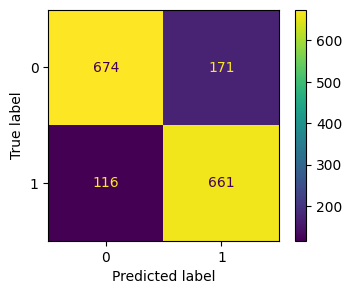

In [283]:
eval_model(X_train_std, y_train, X_val_std, y_val, nb, True)

ACCURACY: 0.7731	PRECISION: 0.6968	RECALL: 0.9318	F1 SCORE: 0.7974	ROC SCORE: 0.8873

 Average recall score: 0.9224


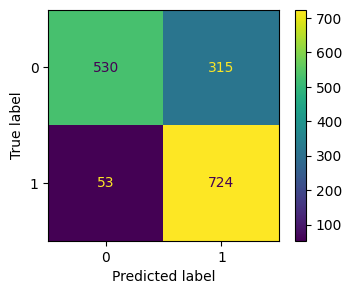

In [285]:
eval_model(X_train_std, y_train, X_val_std, y_val, nb_clf_gridcv.best_estimator_, True)

Based on training model & validation model (after hyperparameter tuning) we can see that the recall score after hyperparameter tuning is higher by ~9%. But we see from the parameter results that the higher the var_smoothing, the better the results, indicating that naive bayes is not suitable to use for this dataset.

ACCURACY: 0.8121	PRECISION: 0.8046	RECALL: 0.8260	F1 SCORE: 0.8151	ROC SCORE: 0.8783



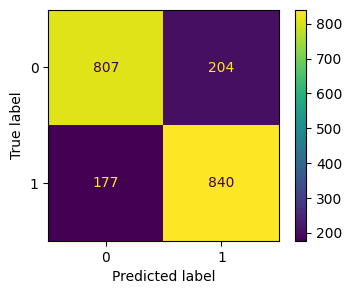

In [286]:
eval_model(X_train_std, y_train, X_test_std, y_test, nb)

The test results align well with the validation data, indicating that the model is neither underfitting nor overfitting. But Naive Bayes is not relevant to use for this dataset.

## **Evaluation**

### **Feature Importance Interpretation**

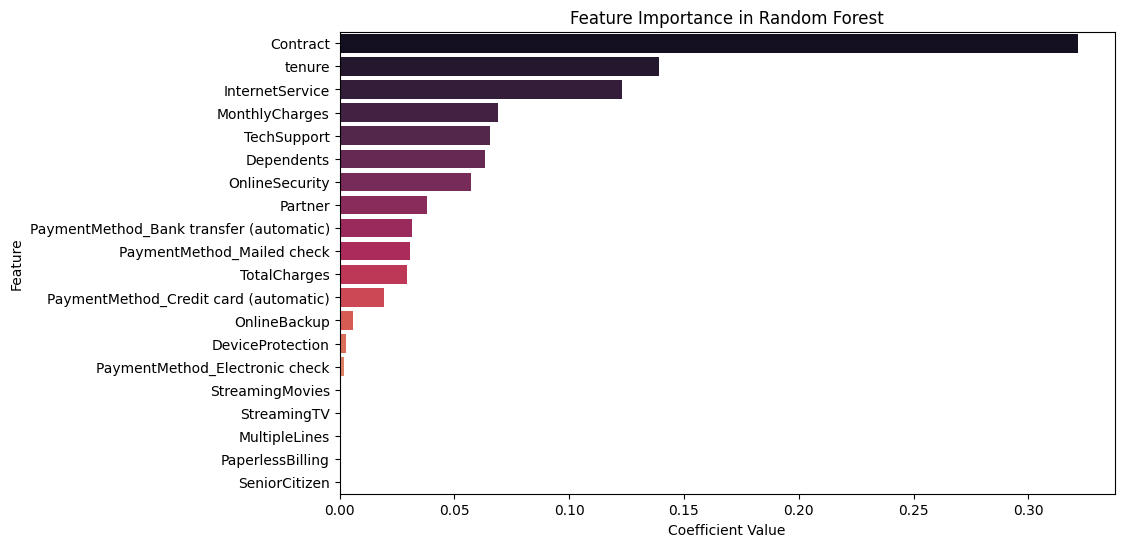

In [289]:
coefficients = rf_clf_gridcv.best_estimator_.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='rocket')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

1. After hyerparameter tuning, every model tested performs better than default if we measure based on recall score.<br/>

2. Naive Bayes is not suitable to use for this dataset due to ascending rankings.<br/>

3. Out of logistic regression and random forest, random forest is the most suitable to use in this dataset due to consistent recall score and is just right, not underfitting nor overfitting, while random forest, cross validation seems to be lower than initial model train. initiating it is overfitting<br/>

4. According to feature importance of the model we used, `Contract`, `tenure`, and `InternetService` are key factors influencing customer churn rate.

## **Conclusion**

Model that will be used for predicting future Telco-Churn data is `Random Forest`.

## **Recommendations**

1. Reevaluate Fiber Optic pricing; e.g. connection speed, performance rating, afterservice, total cost of ownership, future proofing, etc.

2. Provide package bundling especially for Fiber Optic subscribers with fast Tech Support and or Online Security if customers subscribe for a year or over.

3. If customers tend to subscribe to month-to-month contract, contact them after 2 week as a testimony. If their testimony is positive, upsell products or packages with attractive bonuses (e.g., sign a 1-year contract and get 1 month free), and emphasize the advantages of long-term subscriptions, such as cost savings and added services. If their testimony is negative, provide immediate fixes or compensation and follow-up after the issue has been resolved to ensure satisfaction.